[View in Colaboratory](https://colab.research.google.com/github/jamslaugh/My-Datascience-Projects/blob/master/AALOGOPER.ipynb)

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
%reset -f

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import GPUtil as GPU
import os
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.8 GB  | Proc size: 137.4 MB
GPU RAM Free: 11439MB | Used: 0MB | Util   0% | Total 11439MB


In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
import pandas as pd
import datetime
import numpy as np

In [0]:
os.getcwd()
os.listdir("drive")
os.chdir("drive/Colab Notebooks")

In [5]:
os.listdir()

['AALOGOPER.ipynb',
 'kaggle1.ipynb',
 'Untitled0.ipynb',
 'Full_data.csv',
 'Newdata.csv',
 'Deep learning',
 'drive']

In [0]:
data = pd.read_csv('Newdata.csv',index_col = 0,parse_dates=True)

In [0]:
sel_col = data.select_dtypes(include = ["float64","int64"])

In [8]:
sparsity = 1.0 - np.count_nonzero(sel_col) / sel_col.size

print("\n############################# DATA HAS SPARSITY OF {} #############################\n".format(sparsity))


############################# DATA HAS SPARSITY OF 0.9698561414936286 #############################



# Note:

Data is particularly sparse. Random Forest will give a good result with full set of features.<br> However, the feature importance is really low for each vector regarding the single elements. The path to follow seems to be the following, given that feed forward neural networks give really bad results:<br> 
- We can try to study the occurrence over time of each error message.
- Moreover, since the matrix is sparse, we can try to follow a different approach, one based upon CONVNET - LSTM Networks.

In [0]:
from sklearn.decomposition.truncated_svd import TruncatedSVD as tsvd

In [0]:
from sklearn.preprocessing import StandardScaler as ss

In [11]:
printm()

Gen RAM Free: 12.0 GB  | Proc size: 909.7 MB
GPU RAM Free: 11439MB | Used: 0MB | Util   0% | Total 11439MB


In [12]:
from keras.layers import Dense
from keras.layers import Conv1D, MaxPool1D, RNN
from keras.models import Sequential
from keras.optimizers import Adam
from keras import backend as K
import keras
K.tensorflow_backend._get_available_gpus()

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
X = data.iloc[:,2:-1].values
y = data.iloc[:,-1].values

In [0]:
sc = ss()
X = sc.fit_transform(X)

In [0]:
from sklearn.model_selection import train_test_split as tts

In [0]:
X_train, X_test, y_train, y_test = tts(X,y,stratify = y, random_state = 1234,test_size = 0.3)

In [17]:
dec = tsvd(n_components=40)
dec.fit(X_train)
X_train_svd = dec.transform(X_train)
X_test_svd = dec.transform(X_test)
sum(dec.explained_variance_ratio_)

0.9339454047868443

In [0]:
dropped = ['COD_A20','COD_G20','43', '21', '30', '81', '59', '50', '71', '26', '54', '46', '13', '12', 'M2', 'M8', '88', '64', '00', '28', 'PF', '02', '55', '60', '40', '25', '32', '23', '47', '34', '15', '41', '72', 'M1', 'M5', 'N7', 'SC', '48', '24', '51', '27', '29', '97', '31', '33']

In [0]:
from sklearn.ensemble import RandomForestClassifier

# %%

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, roc_curve, auc

In [0]:
import time

In [21]:
t0 = time.time()
clf = RandomForestClassifier(n_estimators = 500, min_samples_split = 25, criterion = "entropy",oob_score = True)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
# %%

print("\n########### Precision score is {} ###########\n".format(precision_score(y_test,pred)))
print("\n########### Recall Score is of {} ###########\n".format(recall_score(y_test,pred)))
print("\n############# F1 Score is of {} #############\n".format(f1_score(y_test,pred)))
print("\n########## Accuracy Score is of {} ##########\n".format(accuracy_score(y_test,pred)))
print("\n###### THE PROCESS LASTED {} SECONDS ########\n".format(time.time() - t0))

# %%
feat_imp = dict()
for el in list(range(len(data.iloc[:,2:-1].columns))):
    feat_imp[list(data.iloc[:,2:-1])[el]] = clf.feature_importances_[el]


########### Precision score is 0.7822164948453608 ###########


########### Recall Score is of 0.8939617083946981 ###########


############# F1 Score is of 0.8343642611683849 #############


########## Accuracy Score is of 0.9877434775975181 ##########


###### THE PROCESS LASTED 35.950756788253784 SECONDS ########



# Plotting ROC curve:

An approach can be the following:


```
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
Plot of a ROC curve for a specific class

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
../../_images/sphx_glr_plot_roc_001.png
Plot ROC curves for the multiclass problem

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
```



In [22]:
print("\n########### Precision score is {} ###########\n".format(precision_score(y_test,pred)))
print("\n########### Recall Score is of {} ###########\n".format(recall_score(y_test,pred)))
print("\n############# F1 Score is of {} #############\n".format(f1_score(y_test,pred)))
print("\n########## Accuracy Score is of {} ##########\n".format(accuracy_score(y_test,pred)))
print("\n###### THE PROCESS LASTED {} SECONDS ########\n".format(time.time() - t0))


########### Precision score is 0.7822164948453608 ###########


########### Recall Score is of 0.8939617083946981 ###########


############# F1 Score is of 0.8343642611683849 #############


########## Accuracy Score is of 0.9877434775975181 ##########


###### THE PROCESS LASTED 44.93943691253662 SECONDS ########



In [23]:
t0 = time.time()
clf1 = RandomForestClassifier(n_estimators = 300, min_samples_split = 25, criterion = "entropy")
clf1.fit(X_train_svd,y_train)
pred1 = clf1.predict(X_test_svd)
# %%

print("\n########## PRECISION SCORE IS {} ############\n".format(precision_score(y_test,pred1)))
print("\n########### RECALL SCORE IS OF {} ###########\n".format(recall_score(y_test,pred1)))
print("\n############# F1 SCORE IS OF {} #############\n".format(f1_score(y_test,pred1)))
print("\n########## ACCURACY SCORE IS OF {} ##########\n".format(accuracy_score(y_test,pred1)))
print("\n###### THE PROCESS LASTED {} SECONDS ########\n".format(time.time() - t0))
# %%
feat_imp1 = dict()
for el in list(range(len(data.iloc[:,2:-1].columns))):
    feat_imp1[list(data.iloc[:,2:-1])[el]] = clf.feature_importances_[el]
    



########## PRECISION SCORE IS 0.7767799871712636 ############


########### RECALL SCORE IS OF 0.8917525773195877 ###########


############# F1 SCORE IS OF 0.8303051079876586 #############


########## ACCURACY SCORE IS OF 0.9874129074912272 ##########


###### THE PROCESS LASTED 93.95625853538513 SECONDS ########



# Note: Truncated SVD

Truncated SVD here doesn't help a lot. Will try with PCA as soon as possible. Data is heavily skewed, however.

### Note: 

SVD will show a consistently higher Recall.

In [0]:
from numpy import loadtxt
from xgboost import XGBClassifier

In [25]:
t0 = time.time()
clf_boost = XGBClassifier(objective = 'binary:logistic',n_estimators = 200,max_leaf_nodes = 6, max_depth = 10,learning_rate = 0.001,gamma = 0.7,reg_lambda = 0.1, 
                          reg_alpha = 0.9, booster = 'gbtree',min_child_weight=0.9)
clf_boost.fit(X_train,y_train)
pred_bo = clf_boost.predict(X_test)

print("\n########## PRECISION SCORE IS {} ############\n".format(precision_score(y_test,pred_bo)))
print("\n########### RECALL SCORE IS OF {} ###########\n".format(recall_score(y_test,pred_bo)))
print("\n############# F1 SCORE IS OF {} #############\n".format(f1_score(y_test,pred_bo)))
print("\n########## ACCURACY SCORE IS OF {} ##########\n".format(accuracy_score(y_test,pred_bo)))
print("\n###### THE PROCESS LASTED {} SECONDS ########\n".format(time.time() - t0))


########## PRECISION SCORE IS 0.7856209150326797 ############


########### RECALL SCORE IS OF 0.8851251840942562 ###########


############# F1 SCORE IS OF 0.832409972299169 #############


########## ACCURACY SCORE IS OF 0.9876926206580888 ##########


###### THE PROCESS LASTED 102.61299991607666 SECONDS ########



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [26]:
print("\n########## PRECISION SCORE IS {} ############\n".format(precision_score(y_test,pred_bo)))
print("\n########### RECALL SCORE IS OF {} ###########\n".format(recall_score(y_test,pred_bo)))
print("\n############# F1 SCORE IS OF {} #############\n".format(f1_score(y_test,pred_bo)))
print("\n########## ACCURACY SCORE IS OF {} ##########\n".format(accuracy_score(y_test,pred_bo)))
print("\n###### THE PROCESS LASTED {} SECONDS ########\n".format(time.time() - t0))


########## PRECISION SCORE IS 0.7856209150326797 ############


########### RECALL SCORE IS OF 0.8851251840942562 ###########


############# F1 SCORE IS OF 0.832409972299169 #############


########## ACCURACY SCORE IS OF 0.9876926206580888 ##########


###### THE PROCESS LASTED 104.07167482376099 SECONDS ########



In [0]:
feat_imp_boost = dict()
for el in list(range(len(data.iloc[:,2:-1].columns))):
    feat_imp_boost[list(data.iloc[:,2:-1])[el]] = clf_boost.feature_importances_[el]


In [28]:
for i, k in feat_imp_boost.items():
  if k > 0:
    print(i,":",k)

COD_A00 : 0.1080108
COD_A70 : 0.022142215
COD_A90 : 0.0360036
COD_A93 : 0.21980198
COD_A94 : 0.09378938
COD_A98 : 0.1440144
COD_F70 : 0.041044105
COD_G70 : 0.04590459
COD_G72 : 0.09522952
COD_LOF : 0.0720072
COD_N70 : 0.036183618
COD_SCC : 0.049864985
COD_V22 : 0.0360036


In [29]:
t0 = time.time()
clf_boost = XGBClassifier(n_estimators = 400,max_leaf_nodes = 6, max_depth = 10,learning_rate = 0.001,gamma = 0.7,reg_lambda = 0.1, reg_alpha = 0.9 ,
                          booster = 'gbtree',min_child_weight=0.9)
clf_boost.fit(X_train_svd,y_train)
pred_bo = clf_boost.predict(X_test_svd)

print("\n########## PRECISION SCORE IS {} ############\n".format(precision_score(y_test,pred_bo)))
print("\n########### RECALL SCORE IS OF {} ###########\n".format(recall_score(y_test,pred_bo)))
print("\n############# F1 SCORE IS OF {} #############\n".format(f1_score(y_test,pred_bo)))
print("\n########## ACCURACY SCORE IS OF {} ##########\n".format(accuracy_score(y_test,pred_bo)))
print("\n###### THE PROCESS LASTED {} SECONDS ########\n".format(time.time() - t0))


########## PRECISION SCORE IS 0.7787096774193548 ############


########### RECALL SCORE IS OF 0.8888070692194403 ###########


############# F1 SCORE IS OF 0.8301237964236589 #############


########## ACCURACY SCORE IS OF 0.9874383359609419 ##########


###### THE PROCESS LASTED 181.69969725608826 SECONDS ########



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [30]:
print("\n########## PRECISION SCORE IS {} ############\n".format(precision_score(y_test,pred_bo)))
print("\n########### RECALL SCORE IS OF {} ###########\n".format(recall_score(y_test,pred_bo)))
print("\n############# F1 SCORE IS OF {} #############\n".format(f1_score(y_test,pred_bo)))
print("\n########## ACCURACY SCORE IS OF {} ##########\n".format(accuracy_score(y_test,pred_bo)))
print("\n###### THE PROCESS LASTED {} SECONDS ########\n".format(time.time() - t0))


########## PRECISION SCORE IS 0.7787096774193548 ############


########### RECALL SCORE IS OF 0.8888070692194403 ###########


############# F1 SCORE IS OF 0.8301237964236589 #############


########## ACCURACY SCORE IS OF 0.9874383359609419 ##########


###### THE PROCESS LASTED 182.41780948638916 SECONDS ########



In [31]:
for i,k in feat_imp_boost.items():
  if k > 0:
    print(i, ":",str(k))

COD_A00 : 0.1080108
COD_A70 : 0.022142215
COD_A90 : 0.0360036
COD_A93 : 0.21980198
COD_A94 : 0.09378938
COD_A98 : 0.1440144
COD_F70 : 0.041044105
COD_G70 : 0.04590459
COD_G72 : 0.09522952
COD_LOF : 0.0720072
COD_N70 : 0.036183618
COD_SCC : 0.049864985
COD_V22 : 0.0360036


In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

In [33]:
data.shape

(131085, 132)

# SVM


SVM imply too much time in training. A different approach will be tried.

---

In [0]:
#kl = SVC(C = 100, gamma = 10,probability = True,kernel="linear")

In [0]:
#X_trainsvm, X_testsvm, y_trainsvm, y_testsvm = tts(X,y,stratify = y,test_size = 0.2,train_size = 0.8)

In [0]:
#t0 = time.time()
#clf2 = AdaBoostClassifier(base_estimator = kl, n_estimators = 10, algorithm = "SAMME.R")
#clf2.fit(X_trainsvm,y_trainsvm)
#predsvm = clf2.predict(X_testsvm)

#print("\n########### Precision score is {} ###########\n".format(precision_score(y_testsvm,predsvm)))
#print("\n########### Recall Score is of {} ###########\n".format(recall_score(y_testsvm,predsvm)))
#print("\n############# F1 Score is of {} #############\n".format(f1_score(y_testsvm,predsvm)))
#print("\n########## Accuracy Score is of {} ##########\n".format(accuracy_score(y_testsvm,predsvm)))
#print(time.time()-t0)



---

# Precision and Recall considerations:

One thing is to note, is the presence of a particular Precision and recall pattern. In particular, with the SVD Precision and Accuracy decrease. <br>Being:
- Precision = TP/(TP + FP) 
- Recall = TP/(TP + FN)
- Accuracy = (TP + FP)/(TP+TN+FP+FN)

We have that with SVD is very likely that the magnitude in increase of False Positives is greater than True Positive increase's one. Therefore, we drop SVD Idea and proceed with only normalized data. 
## Recall Optimization
The algorythm has been optimized wrt Recall. This is because, to me, it seems more critical a non-predicted message error than a predicted one.

# Neural Networks

Feed Forward Neural Networks do not work well. This is mostly due to the sparse nature of the data. A CNN LSTM configuration will be tested (maybe?) in the near future.

## Update:

ANN goes straight to the point. However, data should be more detailed. In particular, it is important having all the data from all machines.

#### Adam:

Adam loss work very well. Also SGD with both high learning rate and medium vanishing does.

In [0]:
opt = Adam(lr=0.003,decay=0.004)

In [0]:
hist = keras.callbacks.History()

In [0]:
model = Sequential()
model.add(Dense(units = 10, activation = 'relu', input_dim = 129 ))
model.add(Dense(units = 15, activation = 'softmax'))
model.add(Dense(units = 5, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [0]:
model.compile(optimizer = opt,loss='binary_crossentropy',metrics = ['accuracy'])

In [41]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size = 400, epochs = 500,callbacks=[hist])

Train on 91759 samples, validate on 39326 samples
Epoch 1/500
91759/91759 [==============================] - 2s 25us/step - loss: 0.1613 - acc: 0.9655 - val_loss: 0.0671 - val_acc: 0.9655
Epoch 2/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0614 - acc: 0.9655 - val_loss: 0.0554 - val_acc: 0.9655
Epoch 3/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0542 - acc: 0.9655 - val_loss: 0.0514 - val_acc: 0.9655
Epoch 4/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0515 - acc: 0.9655 - val_loss: 0.0496 - val_acc: 0.9655
Epoch 5/500
75600/91759 [=======================>......] - ETA: 0s - loss: 0.0501 - acc: 0.9655

91759/91759 [==============================] - 2s 23us/step - loss: 0.0502 - acc: 0.9655 - val_loss: 0.0487 - val_acc: 0.9655
Epoch 6/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0494 - acc: 0.9655 - val_loss: 0.0480 - val_acc: 0.9655
Epoch 7/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0487 - acc: 0.9655 - val_loss: 0.0475 - val_acc: 0.9655
Epoch 8/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0482 - acc: 0.9655 - val_loss: 0.0472 - val_acc: 0.9655
Epoch 9/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0477 - acc: 0.9655 - val_loss: 0.0464 - val_acc: 0.9655
Epoch 10/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0473 - acc: 0.9810 - val_loss: 0.0461 - val_acc: 0.9832
Epoch 11/500
29600/91759 [========>.....................] - ETA: 1s - loss: 0.0463 - acc: 0.9834

91759/91759 [==============================] - 2s 23us/step - loss: 0.0469 - acc: 0.9831 - val_loss: 0.0457 - val_acc: 0.9833
Epoch 12/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0466 - acc: 0.9831 - val_loss: 0.0455 - val_acc: 0.9833
Epoch 13/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0463 - acc: 0.9831 - val_loss: 0.0453 - val_acc: 0.9833
Epoch 14/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0460 - acc: 0.9831 - val_loss: 0.0449 - val_acc: 0.9833
Epoch 15/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0457 - acc: 0.9831 - val_loss: 0.0446 - val_acc: 0.9833
Epoch 16/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0455 - acc: 0.9831 - val_loss: 0.0444 - val_acc: 0.9833
Epoch 17/500
28000/91759 [========>.....................] - ETA: 1s - loss: 0.0455 - acc: 0.9830

91759/91759 [==============================] - 2s 23us/step - loss: 0.0452 - acc: 0.9831 - val_loss: 0.0441 - val_acc: 0.9833
Epoch 18/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0450 - acc: 0.9832 - val_loss: 0.0439 - val_acc: 0.9833
Epoch 19/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0448 - acc: 0.9832 - val_loss: 0.0437 - val_acc: 0.9833
Epoch 20/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0446 - acc: 0.9832 - val_loss: 0.0435 - val_acc: 0.9833
Epoch 21/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0443 - acc: 0.9832 - val_loss: 0.0433 - val_acc: 0.9833
Epoch 22/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0442 - acc: 0.9832 - val_loss: 0.0431 - val_acc: 0.9834
Epoch 23/500
27600/91759 [========>.....................] - ETA: 1s - loss: 0.0464 - acc: 0.9824

91759/91759 [==============================] - 2s 23us/step - loss: 0.0440 - acc: 0.9832 - val_loss: 0.0429 - val_acc: 0.9834
Epoch 24/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0439 - acc: 0.9832 - val_loss: 0.0428 - val_acc: 0.9835
Epoch 25/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0437 - acc: 0.9832 - val_loss: 0.0426 - val_acc: 0.9835
Epoch 26/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0435 - acc: 0.9832 - val_loss: 0.0424 - val_acc: 0.9835
Epoch 27/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0433 - acc: 0.9832 - val_loss: 0.0423 - val_acc: 0.9835
Epoch 28/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0432 - acc: 0.9832 - val_loss: 0.0422 - val_acc: 0.9835
Epoch 29/500
22400/91759 [======>.......................] - ETA: 1s - loss: 0.0453 - acc: 0.9820

91759/91759 [==============================] - 2s 23us/step - loss: 0.0431 - acc: 0.9832 - val_loss: 0.0420 - val_acc: 0.9834
Epoch 30/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0430 - acc: 0.9831 - val_loss: 0.0419 - val_acc: 0.9834
Epoch 31/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0428 - acc: 0.9831 - val_loss: 0.0418 - val_acc: 0.9834
Epoch 32/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0427 - acc: 0.9831 - val_loss: 0.0417 - val_acc: 0.9834
Epoch 33/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0426 - acc: 0.9831 - val_loss: 0.0417 - val_acc: 0.9834
Epoch 34/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0425 - acc: 0.9831 - val_loss: 0.0417 - val_acc: 0.9834
Epoch 35/500
25200/91759 [=======>......................] - ETA: 1s - loss: 0.0454 - acc: 0.9819

91759/91759 [==============================] - 2s 23us/step - loss: 0.0424 - acc: 0.9831 - val_loss: 0.0415 - val_acc: 0.9834
Epoch 36/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0424 - acc: 0.9831 - val_loss: 0.0415 - val_acc: 0.9834
Epoch 37/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0423 - acc: 0.9832 - val_loss: 0.0414 - val_acc: 0.9835
Epoch 38/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0422 - acc: 0.9832 - val_loss: 0.0412 - val_acc: 0.9835
Epoch 39/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0421 - acc: 0.9832 - val_loss: 0.0412 - val_acc: 0.9835
Epoch 40/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0421 - acc: 0.9832 - val_loss: 0.0411 - val_acc: 0.9835
Epoch 41/500
24000/91759 [======>.......................] - ETA: 1s - loss: 0.0425 - acc: 0.9830

91759/91759 [==============================] - 2s 23us/step - loss: 0.0420 - acc: 0.9832 - val_loss: 0.0411 - val_acc: 0.9835
Epoch 42/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0419 - acc: 0.9832 - val_loss: 0.0410 - val_acc: 0.9835
Epoch 43/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0419 - acc: 0.9832 - val_loss: 0.0410 - val_acc: 0.9835
Epoch 44/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0418 - acc: 0.9832 - val_loss: 0.0409 - val_acc: 0.9835
Epoch 45/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0418 - acc: 0.9832 - val_loss: 0.0408 - val_acc: 0.9835
Epoch 46/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0417 - acc: 0.9832 - val_loss: 0.0408 - val_acc: 0.9835
Epoch 47/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0404 - acc: 0.9846

91759/91759 [==============================] - 2s 23us/step - loss: 0.0417 - acc: 0.9832 - val_loss: 0.0407 - val_acc: 0.9835
Epoch 48/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0416 - acc: 0.9832 - val_loss: 0.0407 - val_acc: 0.9835
Epoch 49/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0416 - acc: 0.9832 - val_loss: 0.0406 - val_acc: 0.9835
Epoch 50/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0415 - acc: 0.9832 - val_loss: 0.0406 - val_acc: 0.9835
Epoch 51/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0415 - acc: 0.9832 - val_loss: 0.0406 - val_acc: 0.9835
Epoch 52/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0414 - acc: 0.9832 - val_loss: 0.0405 - val_acc: 0.9835
Epoch 53/500
21600/91759 [======>.......................] - ETA: 1s - loss: 0.0411 - acc: 0.9829

91759/91759 [==============================] - 2s 23us/step - loss: 0.0414 - acc: 0.9832 - val_loss: 0.0405 - val_acc: 0.9835
Epoch 54/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0413 - acc: 0.9832 - val_loss: 0.0404 - val_acc: 0.9835
Epoch 55/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0413 - acc: 0.9832 - val_loss: 0.0404 - val_acc: 0.9835
Epoch 56/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0413 - acc: 0.9833 - val_loss: 0.0403 - val_acc: 0.9835
Epoch 57/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0412 - acc: 0.9833 - val_loss: 0.0404 - val_acc: 0.9839
Epoch 58/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0412 - acc: 0.9834 - val_loss: 0.0403 - val_acc: 0.9839
Epoch 59/500
21200/91759 [=====>........................] - ETA: 1s - loss: 0.0410 - acc: 0.9830

91759/91759 [==============================] - 2s 23us/step - loss: 0.0412 - acc: 0.9836 - val_loss: 0.0403 - val_acc: 0.9840
Epoch 60/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0412 - acc: 0.9836 - val_loss: 0.0402 - val_acc: 0.9839
Epoch 61/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0411 - acc: 0.9836 - val_loss: 0.0402 - val_acc: 0.9840
Epoch 62/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0411 - acc: 0.9837 - val_loss: 0.0402 - val_acc: 0.9840
Epoch 63/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0411 - acc: 0.9837 - val_loss: 0.0401 - val_acc: 0.9840
Epoch 64/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0410 - acc: 0.9837 - val_loss: 0.0401 - val_acc: 0.9840
Epoch 65/500
22000/91759 [======>.......................] - ETA: 1s - loss: 0.0394 - acc: 0.9843

91759/91759 [==============================] - 2s 23us/step - loss: 0.0410 - acc: 0.9837 - val_loss: 0.0401 - val_acc: 0.9840
Epoch 66/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0410 - acc: 0.9837 - val_loss: 0.0401 - val_acc: 0.9840
Epoch 67/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0409 - acc: 0.9837 - val_loss: 0.0400 - val_acc: 0.9840
Epoch 68/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0409 - acc: 0.9837 - val_loss: 0.0400 - val_acc: 0.9840
Epoch 69/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0409 - acc: 0.9837 - val_loss: 0.0400 - val_acc: 0.9840
Epoch 70/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0409 - acc: 0.9837 - val_loss: 0.0400 - val_acc: 0.9840
Epoch 71/500
25200/91759 [=======>......................] - ETA: 1s - loss: 0.0425 - acc: 0.9823

91759/91759 [==============================] - 2s 23us/step - loss: 0.0408 - acc: 0.9837 - val_loss: 0.0399 - val_acc: 0.9840
Epoch 72/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0408 - acc: 0.9837 - val_loss: 0.0399 - val_acc: 0.9840
Epoch 73/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0408 - acc: 0.9837 - val_loss: 0.0399 - val_acc: 0.9840
Epoch 74/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0408 - acc: 0.9837 - val_loss: 0.0399 - val_acc: 0.9840
Epoch 75/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0407 - acc: 0.9837 - val_loss: 0.0398 - val_acc: 0.9840
Epoch 76/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0407 - acc: 0.9837 - val_loss: 0.0398 - val_acc: 0.9840
Epoch 77/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0406 - acc: 0.9833

91759/91759 [==============================] - 2s 23us/step - loss: 0.0407 - acc: 0.9837 - val_loss: 0.0398 - val_acc: 0.9840
Epoch 78/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0407 - acc: 0.9838 - val_loss: 0.0398 - val_acc: 0.9840
Epoch 79/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0407 - acc: 0.9838 - val_loss: 0.0398 - val_acc: 0.9842
Epoch 80/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0407 - acc: 0.9838 - val_loss: 0.0398 - val_acc: 0.9842
Epoch 81/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0406 - acc: 0.9838 - val_loss: 0.0398 - val_acc: 0.9841
Epoch 82/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0406 - acc: 0.9838 - val_loss: 0.0397 - val_acc: 0.9842
Epoch 83/500
22000/91759 [======>.......................] - ETA: 1s - loss: 0.0394 - acc: 0.9840

91759/91759 [==============================] - 2s 23us/step - loss: 0.0406 - acc: 0.9838 - val_loss: 0.0397 - val_acc: 0.9842
Epoch 84/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0406 - acc: 0.9838 - val_loss: 0.0397 - val_acc: 0.9841
Epoch 85/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0406 - acc: 0.9838 - val_loss: 0.0397 - val_acc: 0.9841
Epoch 86/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0406 - acc: 0.9838 - val_loss: 0.0397 - val_acc: 0.9841
Epoch 87/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0405 - acc: 0.9838 - val_loss: 0.0396 - val_acc: 0.9841
Epoch 88/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0405 - acc: 0.9838 - val_loss: 0.0396 - val_acc: 0.9841
Epoch 89/500
25200/91759 [=======>......................] - ETA: 1s - loss: 0.0399 - acc: 0.9848

91759/91759 [==============================] - 2s 23us/step - loss: 0.0405 - acc: 0.9838 - val_loss: 0.0396 - val_acc: 0.9842
Epoch 90/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0405 - acc: 0.9839 - val_loss: 0.0396 - val_acc: 0.9841
Epoch 91/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0405 - acc: 0.9838 - val_loss: 0.0396 - val_acc: 0.9841
Epoch 92/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0405 - acc: 0.9838 - val_loss: 0.0396 - val_acc: 0.9842
Epoch 93/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0404 - acc: 0.9839 - val_loss: 0.0396 - val_acc: 0.9842
Epoch 94/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0404 - acc: 0.9838 - val_loss: 0.0396 - val_acc: 0.9842
Epoch 95/500
22000/91759 [======>.......................] - ETA: 1s - loss: 0.0394 - acc: 0.9840

91759/91759 [==============================] - 2s 23us/step - loss: 0.0404 - acc: 0.9839 - val_loss: 0.0395 - val_acc: 0.9842
Epoch 96/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0404 - acc: 0.9839 - val_loss: 0.0395 - val_acc: 0.9843
Epoch 97/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0404 - acc: 0.9839 - val_loss: 0.0395 - val_acc: 0.9843
Epoch 98/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0404 - acc: 0.9839 - val_loss: 0.0395 - val_acc: 0.9843
Epoch 99/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0404 - acc: 0.9839 - val_loss: 0.0395 - val_acc: 0.9842
Epoch 100/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0403 - acc: 0.9839 - val_loss: 0.0395 - val_acc: 0.9843
Epoch 101/500
24400/91759 [======>.......................] - ETA: 1s - loss: 0.0367 - acc: 0.9850

91759/91759 [==============================] - 2s 23us/step - loss: 0.0403 - acc: 0.9839 - val_loss: 0.0395 - val_acc: 0.9843
Epoch 102/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0403 - acc: 0.9839 - val_loss: 0.0395 - val_acc: 0.9843
Epoch 103/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0403 - acc: 0.9839 - val_loss: 0.0395 - val_acc: 0.9843
Epoch 104/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0403 - acc: 0.9839 - val_loss: 0.0394 - val_acc: 0.9843
Epoch 105/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0402 - acc: 0.9840 - val_loss: 0.0394 - val_acc: 0.9843
Epoch 106/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0402 - acc: 0.9840 - val_loss: 0.0394 - val_acc: 0.9843
Epoch 107/500
22000/91759 [======>.......................] - ETA: 1s - loss: 0.0400 - acc: 0.9840

91759/91759 [==============================] - 2s 23us/step - loss: 0.0402 - acc: 0.9840 - val_loss: 0.0394 - val_acc: 0.9843
Epoch 108/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0402 - acc: 0.9840 - val_loss: 0.0394 - val_acc: 0.9843
Epoch 109/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0402 - acc: 0.9840 - val_loss: 0.0394 - val_acc: 0.9843
Epoch 110/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0402 - acc: 0.9840 - val_loss: 0.0394 - val_acc: 0.9843
Epoch 111/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0402 - acc: 0.9839 - val_loss: 0.0394 - val_acc: 0.9843
Epoch 112/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0402 - acc: 0.9840 - val_loss: 0.0394 - val_acc: 0.9843
Epoch 113/500
24400/91759 [======>.......................] - ETA: 1s - loss: 0.0397 - acc: 0.9843

91759/91759 [==============================] - 2s 23us/step - loss: 0.0401 - acc: 0.9840 - val_loss: 0.0394 - val_acc: 0.9843
Epoch 114/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0401 - acc: 0.9839 - val_loss: 0.0393 - val_acc: 0.9842
Epoch 115/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0401 - acc: 0.9839 - val_loss: 0.0393 - val_acc: 0.9843
Epoch 116/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0401 - acc: 0.9840 - val_loss: 0.0393 - val_acc: 0.9843
Epoch 117/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0401 - acc: 0.9839 - val_loss: 0.0393 - val_acc: 0.9843
Epoch 118/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0401 - acc: 0.9839 - val_loss: 0.0393 - val_acc: 0.9842
Epoch 119/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0402 - acc: 0.9840

91759/91759 [==============================] - 2s 23us/step - loss: 0.0401 - acc: 0.9839 - val_loss: 0.0393 - val_acc: 0.9843
Epoch 120/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0401 - acc: 0.9839 - val_loss: 0.0393 - val_acc: 0.9843
Epoch 121/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0401 - acc: 0.9840 - val_loss: 0.0393 - val_acc: 0.9842
Epoch 122/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0401 - acc: 0.9839 - val_loss: 0.0393 - val_acc: 0.9842
Epoch 123/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0400 - acc: 0.9839 - val_loss: 0.0393 - val_acc: 0.9842
Epoch 124/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0400 - acc: 0.9840 - val_loss: 0.0393 - val_acc: 0.9843
Epoch 125/500
21600/91759 [======>.......................] - ETA: 1s - loss: 0.0399 - acc: 0.9841

91759/91759 [==============================] - 2s 23us/step - loss: 0.0400 - acc: 0.9840 - val_loss: 0.0393 - val_acc: 0.9842
Epoch 126/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0400 - acc: 0.9839 - val_loss: 0.0392 - val_acc: 0.9842
Epoch 127/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0400 - acc: 0.9840 - val_loss: 0.0392 - val_acc: 0.9843
Epoch 128/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0400 - acc: 0.9839 - val_loss: 0.0392 - val_acc: 0.9843
Epoch 129/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0400 - acc: 0.9840 - val_loss: 0.0392 - val_acc: 0.9842
Epoch 130/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0400 - acc: 0.9839 - val_loss: 0.0392 - val_acc: 0.9842
Epoch 131/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0401 - acc: 0.9837

91759/91759 [==============================] - 2s 23us/step - loss: 0.0400 - acc: 0.9839 - val_loss: 0.0392 - val_acc: 0.9842
Epoch 132/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0400 - acc: 0.9839 - val_loss: 0.0392 - val_acc: 0.9842
Epoch 133/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0400 - acc: 0.9839 - val_loss: 0.0392 - val_acc: 0.9843
Epoch 134/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0400 - acc: 0.9839 - val_loss: 0.0392 - val_acc: 0.9843
Epoch 135/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0399 - acc: 0.9839 - val_loss: 0.0392 - val_acc: 0.9842
Epoch 136/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0399 - acc: 0.9840 - val_loss: 0.0392 - val_acc: 0.9842
Epoch 137/500
23600/91759 [======>.......................] - ETA: 1s - loss: 0.0406 - acc: 0.9842

91759/91759 [==============================] - 2s 23us/step - loss: 0.0399 - acc: 0.9839 - val_loss: 0.0392 - val_acc: 0.9843
Epoch 138/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0399 - acc: 0.9840 - val_loss: 0.0391 - val_acc: 0.9843
Epoch 139/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0399 - acc: 0.9840 - val_loss: 0.0391 - val_acc: 0.9843
Epoch 140/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0399 - acc: 0.9839 - val_loss: 0.0391 - val_acc: 0.9843
Epoch 141/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0399 - acc: 0.9839 - val_loss: 0.0391 - val_acc: 0.9843
Epoch 142/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0399 - acc: 0.9839 - val_loss: 0.0391 - val_acc: 0.9843
Epoch 143/500
22000/91759 [======>.......................] - ETA: 1s - loss: 0.0399 - acc: 0.9838

91759/91759 [==============================] - 2s 23us/step - loss: 0.0399 - acc: 0.9839 - val_loss: 0.0391 - val_acc: 0.9842
Epoch 144/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0399 - acc: 0.9840 - val_loss: 0.0391 - val_acc: 0.9843
Epoch 145/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0399 - acc: 0.9839 - val_loss: 0.0391 - val_acc: 0.9843
Epoch 146/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0398 - acc: 0.9839 - val_loss: 0.0391 - val_acc: 0.9843
Epoch 147/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0398 - acc: 0.9840 - val_loss: 0.0391 - val_acc: 0.9843
Epoch 148/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0398 - acc: 0.9840 - val_loss: 0.0391 - val_acc: 0.9843
Epoch 149/500
21600/91759 [======>.......................] - ETA: 1s - loss: 0.0409 - acc: 0.9831

91759/91759 [==============================] - 2s 23us/step - loss: 0.0398 - acc: 0.9839 - val_loss: 0.0391 - val_acc: 0.9843
Epoch 150/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0398 - acc: 0.9839 - val_loss: 0.0391 - val_acc: 0.9843
Epoch 151/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0398 - acc: 0.9839 - val_loss: 0.0391 - val_acc: 0.9843
Epoch 152/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0398 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 153/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0398 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 154/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0398 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 155/500
22800/91759 [======>.......................] - ETA: 1s - loss: 0.0392 - acc: 0.9835

91759/91759 [==============================] - 2s 23us/step - loss: 0.0398 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 156/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0398 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 157/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0398 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 158/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0398 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 159/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0398 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 160/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0398 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 161/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0395 - acc: 0.9842

91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 162/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 163/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 164/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 165/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 166/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 167/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0364 - acc: 0.9852

91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 168/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 169/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 170/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0390 - val_acc: 0.9843
Epoch 171/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 172/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 173/500
21200/91759 [=====>........................] - ETA: 1s - loss: 0.0369 - acc: 0.9847

91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 174/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 175/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 176/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 177/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 178/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 179/500
22400/91759 [======>.......................] - ETA: 1s - loss: 0.0420 - acc: 0.9838

91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 180/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 181/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 182/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 183/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 184/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 185/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0385 - acc: 0.9841

91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 186/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 187/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 188/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 189/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 190/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 191/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0388 - acc: 0.9844

91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 192/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0389 - val_acc: 0.9843
Epoch 193/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 194/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0396 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 195/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 196/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 197/500
19200/91759 [=====>........................] - ETA: 1s - loss: 0.0427 - acc: 0.9831

91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 198/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 199/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 200/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 201/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 202/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 203/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0408 - acc: 0.9837

91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 204/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 205/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 206/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 207/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 208/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9841
Epoch 209/500
21600/91759 [======>.......................] - ETA: 1s - loss: 0.0419 - acc: 0.9829

91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 210/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 211/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 212/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 213/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9843
Epoch 214/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9841
Epoch 215/500
25200/91759 [=======>......................] - ETA: 1s - loss: 0.0428 - acc: 0.9824

91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9843
Epoch 216/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0388 - val_acc: 0.9841
Epoch 217/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 218/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9838 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 219/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9838 - val_loss: 0.0387 - val_acc: 0.9843
Epoch 220/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 221/500
18800/91759 [=====>........................] - ETA: 1s - loss: 0.0381 - acc: 0.9851

91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 222/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9838 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 223/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 224/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 225/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9838 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 226/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9838 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 227/500
19600/91759 [=====>........................] - ETA: 1s - loss: 0.0390 - acc: 0.9841

91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9838 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 228/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 229/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 230/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 231/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 232/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 233/500
24400/91759 [======>.......................] - ETA: 1s - loss: 0.0403 - acc: 0.9831

91759/91759 [==============================] - 2s 22us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 234/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 235/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 236/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9838 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 237/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0394 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 238/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 239/500
24400/91759 [======>.......................] - ETA: 1s - loss: 0.0391 - acc: 0.9846

91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 240/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 241/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 242/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 243/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 244/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9838 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 245/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0392 - acc: 0.9844

91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 246/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9841
Epoch 247/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9841
Epoch 248/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9841
Epoch 249/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9841
Epoch 250/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9841
Epoch 251/500
22000/91759 [======>.......................] - ETA: 1s - loss: 0.0427 - acc: 0.9820

91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9841
Epoch 252/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9841
Epoch 253/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9841
Epoch 254/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9841
Epoch 255/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9841
Epoch 256/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 257/500
22000/91759 [======>.......................] - ETA: 1s - loss: 0.0400 - acc: 0.9828

91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 258/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 259/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 260/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 261/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 262/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 263/500
18800/91759 [=====>........................] - ETA: 1s - loss: 0.0428 - acc: 0.9820

91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 264/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 265/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 266/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 267/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 268/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 269/500
19200/91759 [=====>........................] - ETA: 1s - loss: 0.0371 - acc: 0.9845

91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 270/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 271/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 272/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 273/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 274/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9840 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 275/500
22400/91759 [======>.......................] - ETA: 1s - loss: 0.0415 - acc: 0.9828

91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9840 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 276/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 277/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 278/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 279/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 280/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9840 - val_loss: 0.0385 - val_acc: 0.9842
Epoch 281/500
21200/91759 [=====>........................] - ETA: 1s - loss: 0.0399 - acc: 0.9834

91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 282/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9840 - val_loss: 0.0386 - val_acc: 0.9842
Epoch 283/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9840 - val_loss: 0.0385 - val_acc: 0.9842
Epoch 284/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9840 - val_loss: 0.0385 - val_acc: 0.9842
Epoch 285/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9840 - val_loss: 0.0385 - val_acc: 0.9842
Epoch 286/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9840 - val_loss: 0.0385 - val_acc: 0.9842
Epoch 287/500
22800/91759 [======>.......................] - ETA: 1s - loss: 0.0405 - acc: 0.9838

91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9840 - val_loss: 0.0385 - val_acc: 0.9842
Epoch 288/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9840 - val_loss: 0.0385 - val_acc: 0.9842
Epoch 289/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9841 - val_loss: 0.0385 - val_acc: 0.9842
Epoch 290/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9840 - val_loss: 0.0385 - val_acc: 0.9842
Epoch 291/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9840 - val_loss: 0.0385 - val_acc: 0.9842
Epoch 292/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9840 - val_loss: 0.0385 - val_acc: 0.9842
Epoch 293/500
21600/91759 [======>.......................] - ETA: 1s - loss: 0.0398 - acc: 0.9836

91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9844 - val_loss: 0.0385 - val_acc: 0.9842
Epoch 294/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9841 - val_loss: 0.0385 - val_acc: 0.9842
Epoch 295/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9842 - val_loss: 0.0385 - val_acc: 0.9842
Epoch 296/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0392 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 297/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9841 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 298/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9844 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 299/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0385 - acc: 0.9852

91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 300/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9845 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 301/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 302/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 303/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 304/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 305/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0390 - acc: 0.9849

91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 306/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 307/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 308/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 309/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 310/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 311/500
22000/91759 [======>.......................] - ETA: 1s - loss: 0.0374 - acc: 0.9855

91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 312/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 313/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 314/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 315/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 316/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 317/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0393 - acc: 0.9842

91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 318/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9847 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 319/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9847 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 320/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 321/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9847 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 322/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9847 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 323/500
22400/91759 [======>.......................] - ETA: 1s - loss: 0.0405 - acc: 0.9840

91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9847 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 324/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 325/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 326/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9847 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 327/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9847 - val_loss: 0.0385 - val_acc: 0.9849
Epoch 328/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9847 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 329/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0390 - acc: 0.9841

91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9847 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 330/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0391 - acc: 0.9847 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 331/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9847 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 332/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9847 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 333/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9847 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 334/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9846 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 335/500
22400/91759 [======>.......................] - ETA: 1s - loss: 0.0392 - acc: 0.9850

91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9847 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 336/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9847 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 337/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9847 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 338/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9847 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 339/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9847 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 340/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9846 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 341/500
24400/91759 [======>.......................] - ETA: 1s - loss: 0.0394 - acc: 0.9845

91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9847 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 342/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9849
Epoch 343/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9847 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 344/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9847 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 345/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 346/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 347/500
19200/91759 [=====>........................] - ETA: 1s - loss: 0.0410 - acc: 0.9836

91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 348/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 349/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9850 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 350/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 351/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 352/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 353/500
22000/91759 [======>.......................] - ETA: 1s - loss: 0.0410 - acc: 0.9836

91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 354/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 355/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 356/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 357/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 358/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 359/500
22000/91759 [======>.......................] - ETA: 1s - loss: 0.0398 - acc: 0.9847

91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 360/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 361/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 362/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 363/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 364/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 365/500
25200/91759 [=======>......................] - ETA: 1s - loss: 0.0412 - acc: 0.9837

91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 366/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9853
Epoch 367/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9852 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 368/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 369/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0390 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 370/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 371/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0378 - acc: 0.9859

91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 372/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 373/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 374/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 375/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 376/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 377/500
22000/91759 [======>.......................] - ETA: 1s - loss: 0.0357 - acc: 0.9868

91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 378/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 379/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 380/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 381/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0384 - val_acc: 0.9854
Epoch 382/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 383/500
19200/91759 [=====>........................] - ETA: 1s - loss: 0.0406 - acc: 0.9843

91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 384/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 385/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 386/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 387/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 388/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 389/500
22400/91759 [======>.......................] - ETA: 1s - loss: 0.0402 - acc: 0.9848

91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 390/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 391/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 392/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 393/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 394/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 395/500
19600/91759 [=====>........................] - ETA: 1s - loss: 0.0380 - acc: 0.9853

91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 396/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 397/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 398/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 399/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 400/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 401/500
19600/91759 [=====>........................] - ETA: 1s - loss: 0.0382 - acc: 0.9851

91759/91759 [==============================] - 2s 22us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 402/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 403/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 404/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 405/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 406/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 407/500
25200/91759 [=======>......................] - ETA: 1s - loss: 0.0370 - acc: 0.9858

91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 408/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 409/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 410/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 411/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 412/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 413/500
22400/91759 [======>.......................] - ETA: 1s - loss: 0.0394 - acc: 0.9845

91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 414/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0389 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 415/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 416/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 417/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 418/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 419/500
22400/91759 [======>.......................] - ETA: 1s - loss: 0.0400 - acc: 0.9840

91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 420/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 421/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 422/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 423/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 424/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 425/500
22400/91759 [======>.......................] - ETA: 1s - loss: 0.0383 - acc: 0.9858

91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 426/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 427/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 428/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 429/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 430/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 431/500
25200/91759 [=======>......................] - ETA: 1s - loss: 0.0344 - acc: 0.9869

91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 432/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 433/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 434/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 435/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 436/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 437/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0393 - acc: 0.9847

91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 438/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 439/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 440/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 441/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 442/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 443/500
22000/91759 [======>.......................] - ETA: 1s - loss: 0.0385 - acc: 0.9848

91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0383 - val_acc: 0.9854
Epoch 444/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 445/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 446/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 447/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 448/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 449/500
22000/91759 [======>.......................] - ETA: 1s - loss: 0.0371 - acc: 0.9860

91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 450/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 451/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 452/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 453/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 454/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 455/500
22000/91759 [======>.......................] - ETA: 1s - loss: 0.0387 - acc: 0.9846

91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 456/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 457/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 458/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 459/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 460/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 461/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0406 - acc: 0.9839

91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 462/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 463/500
91759/91759 [==============================] - 2s 22us/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 464/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 465/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 466/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 467/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0402 - acc: 0.9843

91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 468/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 469/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 470/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 471/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 472/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 473/500
19600/91759 [=====>........................] - ETA: 1s - loss: 0.0395 - acc: 0.9852

91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 474/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 475/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 476/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 477/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 478/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 479/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0386 - acc: 0.9852

91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 480/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 481/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 482/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 483/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 484/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 485/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0392 - acc: 0.9846

91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 486/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 487/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 488/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 489/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 490/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 491/500
24800/91759 [=======>......................] - ETA: 1s - loss: 0.0364 - acc: 0.9862

91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 492/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 493/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 494/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 495/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 496/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 497/500
22400/91759 [======>.......................] - ETA: 1s - loss: 0.0405 - acc: 0.9838

91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 498/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 499/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854
Epoch 500/500
91759/91759 [==============================] - 2s 23us/step - loss: 0.0387 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9854


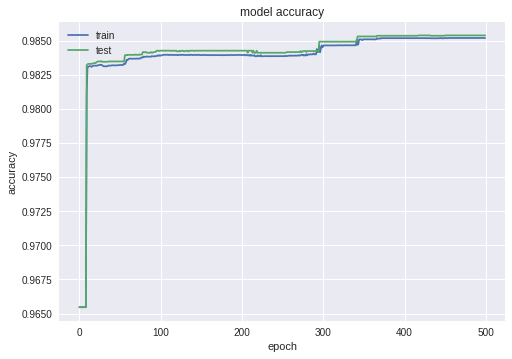

In [42]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

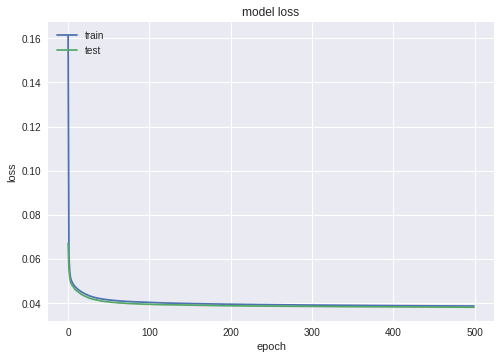

In [43]:

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
model.evaluate(X_test,y_test)

39326/39326 [==============================] - 3s 73us/step


[0.03816475689746172, 0.9853786299140518]

In [0]:
pred = model.predict(X_test)


In [0]:
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [0]:
auc_keras = auc(fpr_keras, tpr_keras)

In [0]:
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

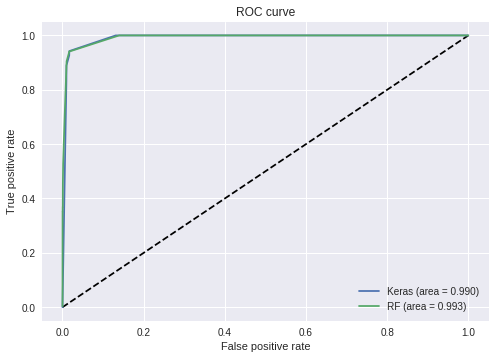

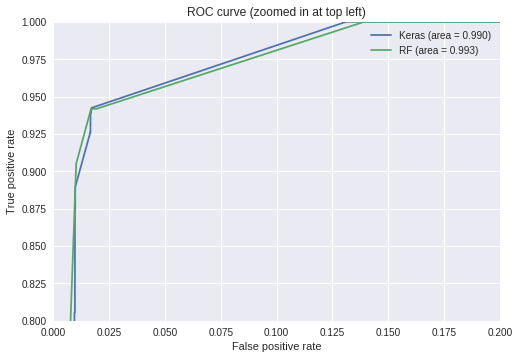

In [49]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# ROC and AUC:

As it is possible to notice, Neural Network will converge much faster than the RF, per false positive rate, to the true positive rate. On the other side, the same convergence will be evaluated in the case of TP vs FN elements. 

In [0]:
lod = []
for el in pred:
  if el >= 0.5:
    lod.append(1)
  else:
    lod.append(0)

In [0]:
lod = np.array(lod)

In [52]:
print("\n########### Precision score is {} ###########\n".format(precision_score(y_test,lod)))
print("\n########### Recall Score is of {} ###########\n".format(recall_score(y_test,lod)))
print("\n############# F1 Score is of {} #############\n".format(f1_score(y_test,lod)))
print("\n########## Accuracy Score is of {} ##########\n".format(accuracy_score(y_test,lod)))


########### Precision score is 0.7584158415841584 ###########


########### Recall Score is of 0.8460972017673049 ###########


############# F1 Score is of 0.7998607727114514 #############


########## Accuracy Score is of 0.9853786299140518 ##########



# NN SVD

In [0]:
opt = Adam(lr=0.0003,decay=0.00001)

In [0]:
model1 = Sequential()
model1.add(Dense(units = 10, activation = 'relu', input_dim = 40 ))
model1.add(Dense(units = 15, activation = 'softmax'))
model1.add(Dense(units = 5, activation = 'relu'))
model1.add(Dense(units = 1, activation = 'sigmoid'))

In [0]:
model1.compile(optimizer = opt,loss='binary_crossentropy',metrics = ['accuracy'])

In [56]:
model1.fit(X_train_svd, y_train, validation_data=(X_test_svd,y_test), batch_size = 100, epochs = 500,callbacks=[hist])

Train on 91759 samples, validate on 39326 samples
Epoch 1/500
91759/91759 [==============================] - 8s 92us/step - loss: 0.3142 - acc: 0.9655 - val_loss: 0.1265 - val_acc: 0.9655
Epoch 2/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0923 - acc: 0.9682 - val_loss: 0.0716 - val_acc: 0.9774
Epoch 3/500
66000/91759 [====================>.........] - ETA: 2s - loss: 0.0686 - acc: 0.9793

91759/91759 [==============================] - 8s 89us/step - loss: 0.0676 - acc: 0.9795 - val_loss: 0.0623 - val_acc: 0.9804
Epoch 4/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0621 - acc: 0.9801 - val_loss: 0.0588 - val_acc: 0.9809
Epoch 5/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0593 - acc: 0.9803 - val_loss: 0.0559 - val_acc: 0.9810
Epoch 6/500
23000/91759 [======>.......................] - ETA: 5s - loss: 0.0550 - acc: 0.9824

91759/91759 [==============================] - 8s 89us/step - loss: 0.0560 - acc: 0.9805 - val_loss: 0.0525 - val_acc: 0.9808
Epoch 7/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0526 - acc: 0.9808 - val_loss: 0.0500 - val_acc: 0.9812
Epoch 8/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0505 - acc: 0.9811 - val_loss: 0.0484 - val_acc: 0.9813
Epoch 9/500
15900/91759 [====>.........................] - ETA: 6s - loss: 0.0505 - acc: 0.9820

91759/91759 [==============================] - 8s 88us/step - loss: 0.0493 - acc: 0.9812 - val_loss: 0.0475 - val_acc: 0.9815
Epoch 10/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0485 - acc: 0.9813 - val_loss: 0.0467 - val_acc: 0.9816
Epoch 11/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0478 - acc: 0.9814 - val_loss: 0.0459 - val_acc: 0.9816
Epoch 12/500
13700/91759 [===>..........................] - ETA: 6s - loss: 0.0485 - acc: 0.9807

91759/91759 [==============================] - 8s 88us/step - loss: 0.0470 - acc: 0.9814 - val_loss: 0.0452 - val_acc: 0.9818
Epoch 13/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0464 - acc: 0.9815 - val_loss: 0.0447 - val_acc: 0.9819
Epoch 14/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0458 - acc: 0.9817 - val_loss: 0.0440 - val_acc: 0.9820
Epoch 15/500
13700/91759 [===>..........................] - ETA: 6s - loss: 0.0460 - acc: 0.9822

91759/91759 [==============================] - 8s 89us/step - loss: 0.0453 - acc: 0.9817 - val_loss: 0.0436 - val_acc: 0.9821
Epoch 16/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0448 - acc: 0.9817 - val_loss: 0.0434 - val_acc: 0.9821
Epoch 17/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0444 - acc: 0.9817 - val_loss: 0.0429 - val_acc: 0.9820
Epoch 18/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0458 - acc: 0.9819

91759/91759 [==============================] - 8s 88us/step - loss: 0.0439 - acc: 0.9817 - val_loss: 0.0426 - val_acc: 0.9821
Epoch 19/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0435 - acc: 0.9817 - val_loss: 0.0423 - val_acc: 0.9820
Epoch 20/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0431 - acc: 0.9818 - val_loss: 0.0417 - val_acc: 0.9820
Epoch 21/500
13400/91759 [===>..........................] - ETA: 6s - loss: 0.0403 - acc: 0.9828

91759/91759 [==============================] - 8s 89us/step - loss: 0.0427 - acc: 0.9821 - val_loss: 0.0412 - val_acc: 0.9821
Epoch 22/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0424 - acc: 0.9827 - val_loss: 0.0411 - val_acc: 0.9833
Epoch 23/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0423 - acc: 0.9832 - val_loss: 0.0405 - val_acc: 0.9833
Epoch 24/500
13700/91759 [===>..........................] - ETA: 6s - loss: 0.0443 - acc: 0.9832

91759/91759 [==============================] - 8s 89us/step - loss: 0.0420 - acc: 0.9832 - val_loss: 0.0404 - val_acc: 0.9834
Epoch 25/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0419 - acc: 0.9832 - val_loss: 0.0401 - val_acc: 0.9834
Epoch 26/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0417 - acc: 0.9832 - val_loss: 0.0400 - val_acc: 0.9833
Epoch 27/500
13700/91759 [===>..........................] - ETA: 6s - loss: 0.0427 - acc: 0.9819

91759/91759 [==============================] - 8s 89us/step - loss: 0.0415 - acc: 0.9832 - val_loss: 0.0398 - val_acc: 0.9834
Epoch 28/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0413 - acc: 0.9832 - val_loss: 0.0396 - val_acc: 0.9834
Epoch 29/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0412 - acc: 0.9832 - val_loss: 0.0396 - val_acc: 0.9835
Epoch 30/500
13800/91759 [===>..........................] - ETA: 6s - loss: 0.0389 - acc: 0.9854

91759/91759 [==============================] - 8s 89us/step - loss: 0.0410 - acc: 0.9832 - val_loss: 0.0394 - val_acc: 0.9834
Epoch 31/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0409 - acc: 0.9832 - val_loss: 0.0394 - val_acc: 0.9835
Epoch 32/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0407 - acc: 0.9833 - val_loss: 0.0393 - val_acc: 0.9835
Epoch 33/500
13700/91759 [===>..........................] - ETA: 6s - loss: 0.0404 - acc: 0.9836

91759/91759 [==============================] - 8s 89us/step - loss: 0.0406 - acc: 0.9833 - val_loss: 0.0395 - val_acc: 0.9834
Epoch 34/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0405 - acc: 0.9833 - val_loss: 0.0392 - val_acc: 0.9835
Epoch 35/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0404 - acc: 0.9833 - val_loss: 0.0394 - val_acc: 0.9834
Epoch 36/500
14600/91759 [===>..........................] - ETA: 6s - loss: 0.0382 - acc: 0.9845

91759/91759 [==============================] - 8s 88us/step - loss: 0.0403 - acc: 0.9833 - val_loss: 0.0387 - val_acc: 0.9835
Epoch 37/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0402 - acc: 0.9832 - val_loss: 0.0387 - val_acc: 0.9835
Epoch 38/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0402 - acc: 0.9833 - val_loss: 0.0386 - val_acc: 0.9835
Epoch 39/500
14200/91759 [===>..........................] - ETA: 6s - loss: 0.0408 - acc: 0.9828

91759/91759 [==============================] - 8s 89us/step - loss: 0.0401 - acc: 0.9832 - val_loss: 0.0386 - val_acc: 0.9835
Epoch 40/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0400 - acc: 0.9835 - val_loss: 0.0385 - val_acc: 0.9835
Epoch 41/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0400 - acc: 0.9835 - val_loss: 0.0387 - val_acc: 0.9835
Epoch 42/500
13900/91759 [===>..........................] - ETA: 6s - loss: 0.0400 - acc: 0.9839

91759/91759 [==============================] - 8s 88us/step - loss: 0.0399 - acc: 0.9834 - val_loss: 0.0384 - val_acc: 0.9835
Epoch 43/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0398 - acc: 0.9834 - val_loss: 0.0384 - val_acc: 0.9838
Epoch 44/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0398 - acc: 0.9840 - val_loss: 0.0383 - val_acc: 0.9837
Epoch 45/500
14500/91759 [===>..........................] - ETA: 6s - loss: 0.0384 - acc: 0.9840

91759/91759 [==============================] - 8s 88us/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0381 - val_acc: 0.9848
Epoch 46/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0395 - acc: 0.9842 - val_loss: 0.0383 - val_acc: 0.9848
Epoch 47/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0395 - acc: 0.9842 - val_loss: 0.0379 - val_acc: 0.9848
Epoch 48/500
13500/91759 [===>..........................] - ETA: 6s - loss: 0.0418 - acc: 0.9839

91759/91759 [==============================] - 8s 88us/step - loss: 0.0395 - acc: 0.9843 - val_loss: 0.0379 - val_acc: 0.9847
Epoch 49/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0394 - acc: 0.9844 - val_loss: 0.0384 - val_acc: 0.9847
Epoch 50/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0394 - acc: 0.9846 - val_loss: 0.0378 - val_acc: 0.9848
Epoch 51/500
13900/91759 [===>..........................] - ETA: 6s - loss: 0.0384 - acc: 0.9835

91759/91759 [==============================] - 8s 88us/step - loss: 0.0393 - acc: 0.9846 - val_loss: 0.0378 - val_acc: 0.9853
Epoch 52/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0392 - acc: 0.9846 - val_loss: 0.0376 - val_acc: 0.9848
Epoch 53/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0392 - acc: 0.9847 - val_loss: 0.0377 - val_acc: 0.9854
Epoch 54/500
13600/91759 [===>..........................] - ETA: 6s - loss: 0.0407 - acc: 0.9840

91759/91759 [==============================] - 8s 88us/step - loss: 0.0391 - acc: 0.9848 - val_loss: 0.0376 - val_acc: 0.9848
Epoch 55/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0390 - acc: 0.9848 - val_loss: 0.0376 - val_acc: 0.9853
Epoch 56/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0389 - acc: 0.9849 - val_loss: 0.0379 - val_acc: 0.9848
Epoch 57/500
13700/91759 [===>..........................] - ETA: 6s - loss: 0.0411 - acc: 0.9845

91759/91759 [==============================] - 8s 88us/step - loss: 0.0390 - acc: 0.9849 - val_loss: 0.0377 - val_acc: 0.9853
Epoch 58/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0388 - acc: 0.9849 - val_loss: 0.0379 - val_acc: 0.9853
Epoch 59/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0389 - acc: 0.9850 - val_loss: 0.0377 - val_acc: 0.9847
Epoch 60/500
13700/91759 [===>..........................] - ETA: 6s - loss: 0.0355 - acc: 0.9854

91759/91759 [==============================] - 8s 88us/step - loss: 0.0387 - acc: 0.9849 - val_loss: 0.0377 - val_acc: 0.9853
Epoch 61/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0387 - acc: 0.9850 - val_loss: 0.0375 - val_acc: 0.9853
Epoch 62/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0386 - acc: 0.9850 - val_loss: 0.0375 - val_acc: 0.9853
Epoch 63/500
14500/91759 [===>..........................] - ETA: 6s - loss: 0.0369 - acc: 0.9854

91759/91759 [==============================] - 8s 87us/step - loss: 0.0385 - acc: 0.9849 - val_loss: 0.0375 - val_acc: 0.9853
Epoch 64/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0386 - acc: 0.9850 - val_loss: 0.0371 - val_acc: 0.9853
Epoch 65/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0385 - acc: 0.9850 - val_loss: 0.0372 - val_acc: 0.9852
Epoch 66/500
13800/91759 [===>..........................] - ETA: 6s - loss: 0.0400 - acc: 0.9841

91759/91759 [==============================] - 8s 88us/step - loss: 0.0385 - acc: 0.9850 - val_loss: 0.0371 - val_acc: 0.9853
Epoch 67/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0384 - acc: 0.9850 - val_loss: 0.0373 - val_acc: 0.9853
Epoch 68/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0383 - acc: 0.9850 - val_loss: 0.0373 - val_acc: 0.9853
Epoch 69/500
13700/91759 [===>..........................] - ETA: 6s - loss: 0.0403 - acc: 0.9842

91759/91759 [==============================] - 8s 88us/step - loss: 0.0383 - acc: 0.9851 - val_loss: 0.0373 - val_acc: 0.9853
Epoch 70/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0383 - acc: 0.9850 - val_loss: 0.0372 - val_acc: 0.9852
Epoch 71/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0382 - acc: 0.9851 - val_loss: 0.0373 - val_acc: 0.9853
Epoch 72/500
13600/91759 [===>..........................] - ETA: 6s - loss: 0.0366 - acc: 0.9856

91759/91759 [==============================] - 8s 88us/step - loss: 0.0382 - acc: 0.9851 - val_loss: 0.0371 - val_acc: 0.9853
Epoch 73/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0381 - acc: 0.9850 - val_loss: 0.0372 - val_acc: 0.9853
Epoch 74/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0382 - acc: 0.9851 - val_loss: 0.0371 - val_acc: 0.9854
Epoch 75/500
13600/91759 [===>..........................] - ETA: 6s - loss: 0.0359 - acc: 0.9859

91759/91759 [==============================] - 8s 89us/step - loss: 0.0380 - acc: 0.9851 - val_loss: 0.0371 - val_acc: 0.9853
Epoch 76/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0381 - acc: 0.9850 - val_loss: 0.0370 - val_acc: 0.9854
Epoch 77/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0380 - acc: 0.9851 - val_loss: 0.0370 - val_acc: 0.9853
Epoch 78/500
13600/91759 [===>..........................] - ETA: 6s - loss: 0.0386 - acc: 0.9851

91759/91759 [==============================] - 8s 89us/step - loss: 0.0380 - acc: 0.9851 - val_loss: 0.0376 - val_acc: 0.9851
Epoch 79/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0380 - acc: 0.9851 - val_loss: 0.0369 - val_acc: 0.9853
Epoch 80/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0380 - acc: 0.9851 - val_loss: 0.0370 - val_acc: 0.9852
Epoch 81/500
14200/91759 [===>..........................] - ETA: 6s - loss: 0.0400 - acc: 0.9844

91759/91759 [==============================] - 8s 89us/step - loss: 0.0379 - acc: 0.9851 - val_loss: 0.0370 - val_acc: 0.9851
Epoch 82/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0379 - acc: 0.9850 - val_loss: 0.0366 - val_acc: 0.9853
Epoch 83/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0379 - acc: 0.9851 - val_loss: 0.0368 - val_acc: 0.9853
Epoch 84/500
13800/91759 [===>..........................] - ETA: 6s - loss: 0.0400 - acc: 0.9848

91759/91759 [==============================] - 8s 89us/step - loss: 0.0379 - acc: 0.9851 - val_loss: 0.0367 - val_acc: 0.9853
Epoch 85/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0378 - acc: 0.9851 - val_loss: 0.0367 - val_acc: 0.9855
Epoch 86/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0378 - acc: 0.9851 - val_loss: 0.0367 - val_acc: 0.9853
Epoch 87/500
13700/91759 [===>..........................] - ETA: 6s - loss: 0.0397 - acc: 0.9840

91759/91759 [==============================] - 8s 89us/step - loss: 0.0378 - acc: 0.9851 - val_loss: 0.0367 - val_acc: 0.9853
Epoch 88/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0378 - acc: 0.9851 - val_loss: 0.0373 - val_acc: 0.9852
Epoch 89/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0377 - acc: 0.9851 - val_loss: 0.0365 - val_acc: 0.9853
Epoch 90/500
14000/91759 [===>..........................] - ETA: 6s - loss: 0.0384 - acc: 0.9846

91759/91759 [==============================] - 8s 88us/step - loss: 0.0377 - acc: 0.9851 - val_loss: 0.0371 - val_acc: 0.9851
Epoch 91/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0377 - acc: 0.9851 - val_loss: 0.0367 - val_acc: 0.9853
Epoch 92/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0377 - acc: 0.9851 - val_loss: 0.0366 - val_acc: 0.9853
Epoch 93/500
13800/91759 [===>..........................] - ETA: 6s - loss: 0.0372 - acc: 0.9849

91759/91759 [==============================] - 8s 88us/step - loss: 0.0377 - acc: 0.9851 - val_loss: 0.0364 - val_acc: 0.9853
Epoch 94/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0377 - acc: 0.9850 - val_loss: 0.0368 - val_acc: 0.9853
Epoch 95/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0376 - acc: 0.9851 - val_loss: 0.0368 - val_acc: 0.9853
Epoch 96/500
14500/91759 [===>..........................] - ETA: 6s - loss: 0.0378 - acc: 0.9846

91759/91759 [==============================] - 8s 88us/step - loss: 0.0376 - acc: 0.9851 - val_loss: 0.0364 - val_acc: 0.9853
Epoch 97/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0376 - acc: 0.9851 - val_loss: 0.0366 - val_acc: 0.9854
Epoch 98/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0375 - acc: 0.9851 - val_loss: 0.0367 - val_acc: 0.9853
Epoch 99/500
14400/91759 [===>..........................] - ETA: 6s - loss: 0.0364 - acc: 0.9845

91759/91759 [==============================] - 8s 88us/step - loss: 0.0374 - acc: 0.9851 - val_loss: 0.0370 - val_acc: 0.9853
Epoch 100/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0375 - acc: 0.9851 - val_loss: 0.0368 - val_acc: 0.9853
Epoch 101/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0374 - acc: 0.9851 - val_loss: 0.0369 - val_acc: 0.9854
Epoch 102/500
13000/91759 [===>..........................] - ETA: 6s - loss: 0.0391 - acc: 0.9857

91759/91759 [==============================] - 8s 88us/step - loss: 0.0375 - acc: 0.9851 - val_loss: 0.0365 - val_acc: 0.9853
Epoch 103/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0375 - acc: 0.9851 - val_loss: 0.0368 - val_acc: 0.9854
Epoch 104/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0374 - acc: 0.9851 - val_loss: 0.0365 - val_acc: 0.9853
Epoch 105/500
12300/91759 [===>..........................] - ETA: 6s - loss: 0.0345 - acc: 0.9867

91759/91759 [==============================] - 8s 88us/step - loss: 0.0373 - acc: 0.9851 - val_loss: 0.0370 - val_acc: 0.9853
Epoch 106/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0373 - acc: 0.9851 - val_loss: 0.0365 - val_acc: 0.9855
Epoch 107/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0374 - acc: 0.9851 - val_loss: 0.0365 - val_acc: 0.9855
Epoch 108/500
12400/91759 [===>..........................] - ETA: 6s - loss: 0.0368 - acc: 0.9861

91759/91759 [==============================] - 8s 88us/step - loss: 0.0374 - acc: 0.9852 - val_loss: 0.0365 - val_acc: 0.9853
Epoch 109/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0373 - acc: 0.9851 - val_loss: 0.0365 - val_acc: 0.9853
Epoch 110/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0372 - acc: 0.9851 - val_loss: 0.0368 - val_acc: 0.9855
Epoch 111/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0360 - acc: 0.9853

91759/91759 [==============================] - 8s 88us/step - loss: 0.0373 - acc: 0.9851 - val_loss: 0.0364 - val_acc: 0.9854
Epoch 112/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0372 - acc: 0.9851 - val_loss: 0.0365 - val_acc: 0.9853
Epoch 113/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0372 - acc: 0.9852 - val_loss: 0.0365 - val_acc: 0.9853
Epoch 114/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0366 - acc: 0.9852

91759/91759 [==============================] - 8s 89us/step - loss: 0.0372 - acc: 0.9852 - val_loss: 0.0369 - val_acc: 0.9854
Epoch 115/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0372 - acc: 0.9851 - val_loss: 0.0365 - val_acc: 0.9855
Epoch 116/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0372 - acc: 0.9851 - val_loss: 0.0366 - val_acc: 0.9855
Epoch 117/500
12500/91759 [===>..........................] - ETA: 6s - loss: 0.0347 - acc: 0.9867

91759/91759 [==============================] - 8s 88us/step - loss: 0.0372 - acc: 0.9852 - val_loss: 0.0364 - val_acc: 0.9853
Epoch 118/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0371 - acc: 0.9852 - val_loss: 0.0366 - val_acc: 0.9853
Epoch 119/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0371 - acc: 0.9852 - val_loss: 0.0365 - val_acc: 0.9853
Epoch 120/500
12300/91759 [===>..........................] - ETA: 6s - loss: 0.0339 - acc: 0.9859

91759/91759 [==============================] - 8s 89us/step - loss: 0.0371 - acc: 0.9852 - val_loss: 0.0367 - val_acc: 0.9854
Epoch 121/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0371 - acc: 0.9852 - val_loss: 0.0363 - val_acc: 0.9855
Epoch 122/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0371 - acc: 0.9852 - val_loss: 0.0364 - val_acc: 0.9855
Epoch 123/500
12200/91759 [==>...........................] - ETA: 6s - loss: 0.0380 - acc: 0.9841

91759/91759 [==============================] - 8s 89us/step - loss: 0.0371 - acc: 0.9852 - val_loss: 0.0363 - val_acc: 0.9855
Epoch 124/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0370 - acc: 0.9853 - val_loss: 0.0363 - val_acc: 0.9853
Epoch 125/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0371 - acc: 0.9852 - val_loss: 0.0366 - val_acc: 0.9854
Epoch 126/500
13000/91759 [===>..........................] - ETA: 6s - loss: 0.0335 - acc: 0.9875

91759/91759 [==============================] - 8s 89us/step - loss: 0.0370 - acc: 0.9852 - val_loss: 0.0365 - val_acc: 0.9853
Epoch 127/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0370 - acc: 0.9852 - val_loss: 0.0365 - val_acc: 0.9853
Epoch 128/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0370 - acc: 0.9852 - val_loss: 0.0369 - val_acc: 0.9854
Epoch 129/500
13300/91759 [===>..........................] - ETA: 6s - loss: 0.0358 - acc: 0.9857

91759/91759 [==============================] - 8s 88us/step - loss: 0.0369 - acc: 0.9853 - val_loss: 0.0365 - val_acc: 0.9853
Epoch 130/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0369 - acc: 0.9852 - val_loss: 0.0364 - val_acc: 0.9853
Epoch 131/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0369 - acc: 0.9853 - val_loss: 0.0366 - val_acc: 0.9854
Epoch 132/500
14400/91759 [===>..........................] - ETA: 6s - loss: 0.0385 - acc: 0.9842

91759/91759 [==============================] - 8s 88us/step - loss: 0.0369 - acc: 0.9852 - val_loss: 0.0365 - val_acc: 0.9853
Epoch 133/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0369 - acc: 0.9852 - val_loss: 0.0363 - val_acc: 0.9855
Epoch 134/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0369 - acc: 0.9852 - val_loss: 0.0366 - val_acc: 0.9854
Epoch 135/500
13000/91759 [===>..........................] - ETA: 6s - loss: 0.0359 - acc: 0.9851

91759/91759 [==============================] - 8s 88us/step - loss: 0.0369 - acc: 0.9852 - val_loss: 0.0363 - val_acc: 0.9855
Epoch 136/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0368 - acc: 0.9852 - val_loss: 0.0362 - val_acc: 0.9855
Epoch 137/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0368 - acc: 0.9852 - val_loss: 0.0363 - val_acc: 0.9856
Epoch 138/500
14000/91759 [===>..........................] - ETA: 6s - loss: 0.0398 - acc: 0.9846

91759/91759 [==============================] - 8s 88us/step - loss: 0.0368 - acc: 0.9853 - val_loss: 0.0363 - val_acc: 0.9854
Epoch 139/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0368 - acc: 0.9853 - val_loss: 0.0364 - val_acc: 0.9855
Epoch 140/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0368 - acc: 0.9853 - val_loss: 0.0363 - val_acc: 0.9855
Epoch 141/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0383 - acc: 0.9845

91759/91759 [==============================] - 8s 88us/step - loss: 0.0368 - acc: 0.9854 - val_loss: 0.0363 - val_acc: 0.9855
Epoch 142/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0367 - acc: 0.9853 - val_loss: 0.0363 - val_acc: 0.9853
Epoch 143/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0367 - acc: 0.9853 - val_loss: 0.0364 - val_acc: 0.9855
Epoch 144/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0391 - acc: 0.9839

91759/91759 [==============================] - 8s 88us/step - loss: 0.0367 - acc: 0.9853 - val_loss: 0.0363 - val_acc: 0.9856
Epoch 145/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0366 - acc: 0.9853 - val_loss: 0.0363 - val_acc: 0.9853
Epoch 146/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0367 - acc: 0.9853 - val_loss: 0.0362 - val_acc: 0.9855
Epoch 147/500
12400/91759 [===>..........................] - ETA: 6s - loss: 0.0364 - acc: 0.9848

91759/91759 [==============================] - 8s 89us/step - loss: 0.0366 - acc: 0.9854 - val_loss: 0.0362 - val_acc: 0.9856
Epoch 148/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0366 - acc: 0.9855 - val_loss: 0.0363 - val_acc: 0.9854
Epoch 149/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0366 - acc: 0.9854 - val_loss: 0.0363 - val_acc: 0.9855
Epoch 150/500
12900/91759 [===>..........................] - ETA: 6s - loss: 0.0384 - acc: 0.9851

91759/91759 [==============================] - 8s 88us/step - loss: 0.0366 - acc: 0.9854 - val_loss: 0.0361 - val_acc: 0.9855
Epoch 151/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0366 - acc: 0.9854 - val_loss: 0.0363 - val_acc: 0.9855
Epoch 152/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0366 - acc: 0.9854 - val_loss: 0.0361 - val_acc: 0.9856
Epoch 153/500
12300/91759 [===>..........................] - ETA: 6s - loss: 0.0329 - acc: 0.9867

91759/91759 [==============================] - 8s 89us/step - loss: 0.0365 - acc: 0.9854 - val_loss: 0.0362 - val_acc: 0.9855
Epoch 154/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0366 - acc: 0.9854 - val_loss: 0.0361 - val_acc: 0.9855
Epoch 155/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0365 - acc: 0.9854 - val_loss: 0.0361 - val_acc: 0.9856
Epoch 156/500
12500/91759 [===>..........................] - ETA: 6s - loss: 0.0389 - acc: 0.9840

91759/91759 [==============================] - 8s 90us/step - loss: 0.0365 - acc: 0.9854 - val_loss: 0.0364 - val_acc: 0.9856
Epoch 157/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0364 - acc: 0.9855 - val_loss: 0.0361 - val_acc: 0.9864
Epoch 158/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0365 - acc: 0.9855 - val_loss: 0.0362 - val_acc: 0.9865
Epoch 159/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0368 - acc: 0.9871

91759/91759 [==============================] - 8s 89us/step - loss: 0.0364 - acc: 0.9856 - val_loss: 0.0360 - val_acc: 0.9856
Epoch 160/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0365 - acc: 0.9855 - val_loss: 0.0361 - val_acc: 0.9856
Epoch 161/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0365 - acc: 0.9855 - val_loss: 0.0360 - val_acc: 0.9855
Epoch 162/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0376 - acc: 0.9851

91759/91759 [==============================] - 8s 89us/step - loss: 0.0365 - acc: 0.9855 - val_loss: 0.0362 - val_acc: 0.9856
Epoch 163/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0363 - acc: 0.9855 - val_loss: 0.0364 - val_acc: 0.9865
Epoch 164/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0363 - acc: 0.9855 - val_loss: 0.0360 - val_acc: 0.9864
Epoch 165/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0341 - acc: 0.9857

91759/91759 [==============================] - 8s 89us/step - loss: 0.0363 - acc: 0.9855 - val_loss: 0.0361 - val_acc: 0.9855
Epoch 166/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0363 - acc: 0.9855 - val_loss: 0.0362 - val_acc: 0.9856
Epoch 167/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0364 - acc: 0.9856 - val_loss: 0.0362 - val_acc: 0.9856
Epoch 168/500
12400/91759 [===>..........................] - ETA: 6s - loss: 0.0358 - acc: 0.9857

91759/91759 [==============================] - 8s 88us/step - loss: 0.0363 - acc: 0.9855 - val_loss: 0.0364 - val_acc: 0.9855
Epoch 169/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0363 - acc: 0.9855 - val_loss: 0.0360 - val_acc: 0.9855
Epoch 170/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0363 - acc: 0.9855 - val_loss: 0.0360 - val_acc: 0.9855
Epoch 171/500
12300/91759 [===>..........................] - ETA: 6s - loss: 0.0351 - acc: 0.9864

91759/91759 [==============================] - 8s 89us/step - loss: 0.0364 - acc: 0.9855 - val_loss: 0.0359 - val_acc: 0.9856
Epoch 172/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0363 - acc: 0.9854 - val_loss: 0.0364 - val_acc: 0.9855
Epoch 173/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0363 - acc: 0.9854 - val_loss: 0.0359 - val_acc: 0.9864
Epoch 174/500
13000/91759 [===>..........................] - ETA: 6s - loss: 0.0386 - acc: 0.9850

91759/91759 [==============================] - 8s 89us/step - loss: 0.0362 - acc: 0.9857 - val_loss: 0.0361 - val_acc: 0.9855
Epoch 175/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0362 - acc: 0.9856 - val_loss: 0.0361 - val_acc: 0.9855
Epoch 176/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0362 - acc: 0.9855 - val_loss: 0.0361 - val_acc: 0.9855
Epoch 177/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0356 - acc: 0.9856

91759/91759 [==============================] - 8s 88us/step - loss: 0.0362 - acc: 0.9855 - val_loss: 0.0360 - val_acc: 0.9855
Epoch 178/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0362 - acc: 0.9855 - val_loss: 0.0358 - val_acc: 0.9856
Epoch 179/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0362 - acc: 0.9856 - val_loss: 0.0358 - val_acc: 0.9855
Epoch 180/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0407 - acc: 0.9836

91759/91759 [==============================] - 8s 88us/step - loss: 0.0362 - acc: 0.9855 - val_loss: 0.0359 - val_acc: 0.9855
Epoch 181/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0361 - acc: 0.9857 - val_loss: 0.0360 - val_acc: 0.9864
Epoch 182/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0362 - acc: 0.9857 - val_loss: 0.0362 - val_acc: 0.9864
Epoch 183/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0355 - acc: 0.9850

91759/91759 [==============================] - 8s 88us/step - loss: 0.0361 - acc: 0.9857 - val_loss: 0.0359 - val_acc: 0.9865
Epoch 184/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0361 - acc: 0.9856 - val_loss: 0.0360 - val_acc: 0.9855
Epoch 185/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0362 - acc: 0.9857 - val_loss: 0.0358 - val_acc: 0.9864
Epoch 186/500
13000/91759 [===>..........................] - ETA: 6s - loss: 0.0383 - acc: 0.9857

91759/91759 [==============================] - 8s 88us/step - loss: 0.0361 - acc: 0.9856 - val_loss: 0.0358 - val_acc: 0.9856
Epoch 187/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0361 - acc: 0.9856 - val_loss: 0.0360 - val_acc: 0.9855
Epoch 188/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0361 - acc: 0.9856 - val_loss: 0.0358 - val_acc: 0.9865
Epoch 189/500
13800/91759 [===>..........................] - ETA: 6s - loss: 0.0346 - acc: 0.9867

91759/91759 [==============================] - 8s 88us/step - loss: 0.0361 - acc: 0.9857 - val_loss: 0.0358 - val_acc: 0.9865
Epoch 190/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0361 - acc: 0.9857 - val_loss: 0.0358 - val_acc: 0.9855
Epoch 191/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0361 - acc: 0.9856 - val_loss: 0.0357 - val_acc: 0.9855
Epoch 192/500
13000/91759 [===>..........................] - ETA: 6s - loss: 0.0372 - acc: 0.9857

91759/91759 [==============================] - 8s 88us/step - loss: 0.0360 - acc: 0.9857 - val_loss: 0.0358 - val_acc: 0.9855
Epoch 193/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0360 - acc: 0.9857 - val_loss: 0.0358 - val_acc: 0.9855
Epoch 194/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0360 - acc: 0.9857 - val_loss: 0.0359 - val_acc: 0.9855
Epoch 195/500
13700/91759 [===>..........................] - ETA: 6s - loss: 0.0350 - acc: 0.9856

91759/91759 [==============================] - 8s 89us/step - loss: 0.0360 - acc: 0.9858 - val_loss: 0.0358 - val_acc: 0.9864
Epoch 196/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0360 - acc: 0.9857 - val_loss: 0.0357 - val_acc: 0.9865
Epoch 197/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0359 - acc: 0.9859 - val_loss: 0.0361 - val_acc: 0.9855
Epoch 198/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0367 - acc: 0.9856

91759/91759 [==============================] - 8s 88us/step - loss: 0.0360 - acc: 0.9858 - val_loss: 0.0358 - val_acc: 0.9855
Epoch 199/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0360 - acc: 0.9858 - val_loss: 0.0357 - val_acc: 0.9864
Epoch 200/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0360 - acc: 0.9859 - val_loss: 0.0357 - val_acc: 0.9856
Epoch 201/500
13000/91759 [===>..........................] - ETA: 6s - loss: 0.0370 - acc: 0.9851

91759/91759 [==============================] - 8s 88us/step - loss: 0.0359 - acc: 0.9857 - val_loss: 0.0356 - val_acc: 0.9864
Epoch 202/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0358 - acc: 0.9859 - val_loss: 0.0357 - val_acc: 0.9855
Epoch 203/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0358 - acc: 0.9859 - val_loss: 0.0358 - val_acc: 0.9854
Epoch 204/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0362 - acc: 0.9859

91759/91759 [==============================] - 8s 89us/step - loss: 0.0359 - acc: 0.9859 - val_loss: 0.0359 - val_acc: 0.9856
Epoch 205/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0359 - acc: 0.9857 - val_loss: 0.0356 - val_acc: 0.9865
Epoch 206/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0358 - acc: 0.9859 - val_loss: 0.0356 - val_acc: 0.9865
Epoch 207/500
12900/91759 [===>..........................] - ETA: 6s - loss: 0.0374 - acc: 0.9851

91759/91759 [==============================] - 8s 89us/step - loss: 0.0358 - acc: 0.9858 - val_loss: 0.0357 - val_acc: 0.9855
Epoch 208/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0358 - acc: 0.9857 - val_loss: 0.0357 - val_acc: 0.9855
Epoch 209/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0358 - acc: 0.9859 - val_loss: 0.0355 - val_acc: 0.9865
Epoch 210/500
13000/91759 [===>..........................] - ETA: 6s - loss: 0.0349 - acc: 0.9862

91759/91759 [==============================] - 8s 89us/step - loss: 0.0358 - acc: 0.9859 - val_loss: 0.0356 - val_acc: 0.9855
Epoch 211/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0358 - acc: 0.9858 - val_loss: 0.0356 - val_acc: 0.9865
Epoch 212/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0357 - acc: 0.9860 - val_loss: 0.0355 - val_acc: 0.9864
Epoch 213/500
12400/91759 [===>..........................] - ETA: 6s - loss: 0.0364 - acc: 0.9863

91759/91759 [==============================] - 8s 89us/step - loss: 0.0357 - acc: 0.9860 - val_loss: 0.0356 - val_acc: 0.9856
Epoch 214/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0357 - acc: 0.9860 - val_loss: 0.0356 - val_acc: 0.9854
Epoch 215/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0357 - acc: 0.9860 - val_loss: 0.0354 - val_acc: 0.9866
Epoch 216/500
12400/91759 [===>..........................] - ETA: 6s - loss: 0.0383 - acc: 0.9855

91759/91759 [==============================] - 8s 89us/step - loss: 0.0356 - acc: 0.9860 - val_loss: 0.0356 - val_acc: 0.9854
Epoch 217/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0357 - acc: 0.9859 - val_loss: 0.0356 - val_acc: 0.9854
Epoch 218/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0356 - acc: 0.9858 - val_loss: 0.0357 - val_acc: 0.9865
Epoch 219/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0356 - acc: 0.9866

91759/91759 [==============================] - 8s 89us/step - loss: 0.0356 - acc: 0.9860 - val_loss: 0.0355 - val_acc: 0.9864
Epoch 220/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0356 - acc: 0.9860 - val_loss: 0.0356 - val_acc: 0.9864
Epoch 221/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0357 - acc: 0.9861 - val_loss: 0.0357 - val_acc: 0.9855
Epoch 222/500
12200/91759 [==>...........................] - ETA: 6s - loss: 0.0397 - acc: 0.9839

91759/91759 [==============================] - 8s 89us/step - loss: 0.0356 - acc: 0.9860 - val_loss: 0.0357 - val_acc: 0.9854
Epoch 223/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0356 - acc: 0.9861 - val_loss: 0.0355 - val_acc: 0.9864
Epoch 224/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0356 - acc: 0.9860 - val_loss: 0.0361 - val_acc: 0.9865
Epoch 225/500
12400/91759 [===>..........................] - ETA: 6s - loss: 0.0356 - acc: 0.9853

91759/91759 [==============================] - 8s 89us/step - loss: 0.0356 - acc: 0.9860 - val_loss: 0.0355 - val_acc: 0.9856
Epoch 226/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0356 - acc: 0.9861 - val_loss: 0.0356 - val_acc: 0.9854
Epoch 227/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0355 - acc: 0.9862 - val_loss: 0.0360 - val_acc: 0.9864
Epoch 228/500
12300/91759 [===>..........................] - ETA: 6s - loss: 0.0388 - acc: 0.9848

91759/91759 [==============================] - 8s 89us/step - loss: 0.0356 - acc: 0.9861 - val_loss: 0.0357 - val_acc: 0.9865
Epoch 229/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0355 - acc: 0.9860 - val_loss: 0.0358 - val_acc: 0.9854
Epoch 230/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0355 - acc: 0.9861 - val_loss: 0.0355 - val_acc: 0.9865
Epoch 231/500
12400/91759 [===>..........................] - ETA: 6s - loss: 0.0361 - acc: 0.9851

91759/91759 [==============================] - 8s 89us/step - loss: 0.0355 - acc: 0.9861 - val_loss: 0.0356 - val_acc: 0.9864
Epoch 232/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0355 - acc: 0.9862 - val_loss: 0.0353 - val_acc: 0.9864
Epoch 233/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0355 - acc: 0.9861 - val_loss: 0.0354 - val_acc: 0.9865
Epoch 234/500
13200/91759 [===>..........................] - ETA: 6s - loss: 0.0422 - acc: 0.9840

91759/91759 [==============================] - 8s 88us/step - loss: 0.0355 - acc: 0.9861 - val_loss: 0.0353 - val_acc: 0.9866
Epoch 235/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0354 - acc: 0.9862 - val_loss: 0.0353 - val_acc: 0.9864
Epoch 236/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0355 - acc: 0.9861 - val_loss: 0.0355 - val_acc: 0.9865
Epoch 237/500
13300/91759 [===>..........................] - ETA: 6s - loss: 0.0352 - acc: 0.9862

91759/91759 [==============================] - 8s 88us/step - loss: 0.0355 - acc: 0.9862 - val_loss: 0.0356 - val_acc: 0.9863
Epoch 238/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0355 - acc: 0.9862 - val_loss: 0.0353 - val_acc: 0.9865
Epoch 239/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0354 - acc: 0.9861 - val_loss: 0.0353 - val_acc: 0.9864
Epoch 240/500
13800/91759 [===>..........................] - ETA: 6s - loss: 0.0342 - acc: 0.9865

91759/91759 [==============================] - 8s 88us/step - loss: 0.0354 - acc: 0.9862 - val_loss: 0.0354 - val_acc: 0.9864
Epoch 241/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0354 - acc: 0.9861 - val_loss: 0.0354 - val_acc: 0.9865
Epoch 242/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0353 - acc: 0.9862 - val_loss: 0.0354 - val_acc: 0.9854
Epoch 243/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0354 - acc: 0.9861

91759/91759 [==============================] - 8s 88us/step - loss: 0.0354 - acc: 0.9862 - val_loss: 0.0354 - val_acc: 0.9864
Epoch 244/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0354 - acc: 0.9863 - val_loss: 0.0358 - val_acc: 0.9856
Epoch 245/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0353 - acc: 0.9862 - val_loss: 0.0354 - val_acc: 0.9855
Epoch 246/500
13700/91759 [===>..........................] - ETA: 6s - loss: 0.0320 - acc: 0.9874

91759/91759 [==============================] - 8s 88us/step - loss: 0.0353 - acc: 0.9862 - val_loss: 0.0353 - val_acc: 0.9865
Epoch 247/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0354 - acc: 0.9862 - val_loss: 0.0355 - val_acc: 0.9855
Epoch 248/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0353 - acc: 0.9862 - val_loss: 0.0353 - val_acc: 0.9863
Epoch 249/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0369 - acc: 0.9853

91759/91759 [==============================] - 8s 88us/step - loss: 0.0353 - acc: 0.9862 - val_loss: 0.0355 - val_acc: 0.9854
Epoch 250/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0354 - acc: 0.9862 - val_loss: 0.0353 - val_acc: 0.9864
Epoch 251/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0353 - acc: 0.9862 - val_loss: 0.0352 - val_acc: 0.9864
Epoch 252/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0332 - acc: 0.9880

91759/91759 [==============================] - 8s 88us/step - loss: 0.0353 - acc: 0.9863 - val_loss: 0.0354 - val_acc: 0.9863
Epoch 253/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0353 - acc: 0.9863 - val_loss: 0.0353 - val_acc: 0.9864
Epoch 254/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0352 - acc: 0.9861 - val_loss: 0.0351 - val_acc: 0.9865
Epoch 255/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0358 - acc: 0.9851

91759/91759 [==============================] - 8s 88us/step - loss: 0.0353 - acc: 0.9862 - val_loss: 0.0353 - val_acc: 0.9864
Epoch 256/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0353 - acc: 0.9862 - val_loss: 0.0353 - val_acc: 0.9865
Epoch 257/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0353 - acc: 0.9864 - val_loss: 0.0353 - val_acc: 0.9864
Epoch 258/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0355 - acc: 0.9869

91759/91759 [==============================] - 8s 88us/step - loss: 0.0352 - acc: 0.9863 - val_loss: 0.0353 - val_acc: 0.9864
Epoch 259/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0353 - acc: 0.9863 - val_loss: 0.0352 - val_acc: 0.9865
Epoch 260/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0352 - acc: 0.9863 - val_loss: 0.0353 - val_acc: 0.9865
Epoch 261/500
13300/91759 [===>..........................] - ETA: 6s - loss: 0.0360 - acc: 0.9860

91759/91759 [==============================] - 8s 87us/step - loss: 0.0352 - acc: 0.9863 - val_loss: 0.0352 - val_acc: 0.9865
Epoch 262/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0352 - acc: 0.9863 - val_loss: 0.0352 - val_acc: 0.9864
Epoch 263/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0352 - acc: 0.9863 - val_loss: 0.0352 - val_acc: 0.9864
Epoch 264/500
13200/91759 [===>..........................] - ETA: 6s - loss: 0.0379 - acc: 0.9852

91759/91759 [==============================] - 8s 88us/step - loss: 0.0352 - acc: 0.9863 - val_loss: 0.0353 - val_acc: 0.9866
Epoch 265/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0352 - acc: 0.9863 - val_loss: 0.0353 - val_acc: 0.9863
Epoch 266/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0352 - acc: 0.9863 - val_loss: 0.0352 - val_acc: 0.9865
Epoch 267/500
13200/91759 [===>..........................] - ETA: 6s - loss: 0.0336 - acc: 0.9862

91759/91759 [==============================] - 8s 88us/step - loss: 0.0351 - acc: 0.9863 - val_loss: 0.0353 - val_acc: 0.9864
Epoch 268/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0352 - acc: 0.9863 - val_loss: 0.0352 - val_acc: 0.9864
Epoch 269/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0352 - acc: 0.9863 - val_loss: 0.0352 - val_acc: 0.9864
Epoch 270/500
13200/91759 [===>..........................] - ETA: 6s - loss: 0.0356 - acc: 0.9866

91759/91759 [==============================] - 8s 88us/step - loss: 0.0352 - acc: 0.9863 - val_loss: 0.0351 - val_acc: 0.9865
Epoch 271/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0351 - acc: 0.9862 - val_loss: 0.0351 - val_acc: 0.9865
Epoch 272/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0352 - acc: 0.9863 - val_loss: 0.0358 - val_acc: 0.9855
Epoch 273/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0324 - acc: 0.9869

91759/91759 [==============================] - 8s 88us/step - loss: 0.0351 - acc: 0.9863 - val_loss: 0.0351 - val_acc: 0.9864
Epoch 274/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0351 - acc: 0.9863 - val_loss: 0.0352 - val_acc: 0.9864
Epoch 275/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0351 - acc: 0.9863 - val_loss: 0.0352 - val_acc: 0.9865
Epoch 276/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0342 - acc: 0.9878

91759/91759 [==============================] - 8s 89us/step - loss: 0.0351 - acc: 0.9863 - val_loss: 0.0351 - val_acc: 0.9865
Epoch 277/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0350 - acc: 0.9863 - val_loss: 0.0351 - val_acc: 0.9865
Epoch 278/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0351 - acc: 0.9863 - val_loss: 0.0357 - val_acc: 0.9865
Epoch 279/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0369 - acc: 0.9852

91759/91759 [==============================] - 8s 88us/step - loss: 0.0351 - acc: 0.9863 - val_loss: 0.0351 - val_acc: 0.9864
Epoch 280/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0351 - acc: 0.9864 - val_loss: 0.0353 - val_acc: 0.9870
Epoch 281/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0350 - acc: 0.9864 - val_loss: 0.0351 - val_acc: 0.9865
Epoch 282/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0341 - acc: 0.9873

91759/91759 [==============================] - 8s 88us/step - loss: 0.0350 - acc: 0.9863 - val_loss: 0.0355 - val_acc: 0.9864
Epoch 283/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0351 - acc: 0.9863 - val_loss: 0.0350 - val_acc: 0.9866
Epoch 284/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0350 - acc: 0.9863 - val_loss: 0.0352 - val_acc: 0.9866
Epoch 285/500
12600/91759 [===>..........................] - ETA: 6s - loss: 0.0361 - acc: 0.9862

91759/91759 [==============================] - 8s 89us/step - loss: 0.0349 - acc: 0.9864 - val_loss: 0.0352 - val_acc: 0.9865
Epoch 286/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0350 - acc: 0.9864 - val_loss: 0.0353 - val_acc: 0.9869
Epoch 287/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0350 - acc: 0.9863 - val_loss: 0.0352 - val_acc: 0.9864
Epoch 288/500
12300/91759 [===>..........................] - ETA: 6s - loss: 0.0365 - acc: 0.9864

91759/91759 [==============================] - 8s 88us/step - loss: 0.0350 - acc: 0.9864 - val_loss: 0.0351 - val_acc: 0.9866
Epoch 289/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0350 - acc: 0.9865 - val_loss: 0.0350 - val_acc: 0.9865
Epoch 290/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0350 - acc: 0.9865 - val_loss: 0.0351 - val_acc: 0.9865
Epoch 291/500
13600/91759 [===>..........................] - ETA: 6s - loss: 0.0340 - acc: 0.9867

91759/91759 [==============================] - 8s 88us/step - loss: 0.0350 - acc: 0.9864 - val_loss: 0.0350 - val_acc: 0.9865
Epoch 292/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0350 - acc: 0.9864 - val_loss: 0.0351 - val_acc: 0.9864
Epoch 293/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0349 - acc: 0.9864 - val_loss: 0.0350 - val_acc: 0.9865
Epoch 294/500
13200/91759 [===>..........................] - ETA: 6s - loss: 0.0387 - acc: 0.9868

91759/91759 [==============================] - 8s 88us/step - loss: 0.0350 - acc: 0.9864 - val_loss: 0.0353 - val_acc: 0.9865
Epoch 295/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0349 - acc: 0.9864 - val_loss: 0.0349 - val_acc: 0.9866
Epoch 296/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0350 - acc: 0.9864 - val_loss: 0.0349 - val_acc: 0.9866
Epoch 297/500
14000/91759 [===>..........................] - ETA: 6s - loss: 0.0399 - acc: 0.9844

91759/91759 [==============================] - 8s 88us/step - loss: 0.0349 - acc: 0.9865 - val_loss: 0.0351 - val_acc: 0.9865
Epoch 298/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0349 - acc: 0.9865 - val_loss: 0.0350 - val_acc: 0.9866
Epoch 299/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0349 - acc: 0.9865 - val_loss: 0.0350 - val_acc: 0.9865
Epoch 300/500
13800/91759 [===>..........................] - ETA: 6s - loss: 0.0338 - acc: 0.9866

91759/91759 [==============================] - 8s 89us/step - loss: 0.0349 - acc: 0.9865 - val_loss: 0.0349 - val_acc: 0.9866
Epoch 301/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0349 - acc: 0.9864 - val_loss: 0.0350 - val_acc: 0.9865
Epoch 302/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0349 - acc: 0.9865 - val_loss: 0.0351 - val_acc: 0.9870
Epoch 303/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0342 - acc: 0.9863

91759/91759 [==============================] - 8s 88us/step - loss: 0.0349 - acc: 0.9864 - val_loss: 0.0350 - val_acc: 0.9865
Epoch 304/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0349 - acc: 0.9864 - val_loss: 0.0350 - val_acc: 0.9870
Epoch 305/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0348 - acc: 0.9865 - val_loss: 0.0353 - val_acc: 0.9869
Epoch 306/500
13500/91759 [===>..........................] - ETA: 6s - loss: 0.0358 - acc: 0.9866

91759/91759 [==============================] - 8s 89us/step - loss: 0.0349 - acc: 0.9865 - val_loss: 0.0349 - val_acc: 0.9870
Epoch 307/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0348 - acc: 0.9865 - val_loss: 0.0349 - val_acc: 0.9866
Epoch 308/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0349 - acc: 0.9865 - val_loss: 0.0349 - val_acc: 0.9869
Epoch 309/500
12200/91759 [==>...........................] - ETA: 6s - loss: 0.0357 - acc: 0.9853

91759/91759 [==============================] - 8s 90us/step - loss: 0.0348 - acc: 0.9866 - val_loss: 0.0350 - val_acc: 0.9865
Epoch 310/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0349 - acc: 0.9865 - val_loss: 0.0349 - val_acc: 0.9865
Epoch 311/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0348 - acc: 0.9865 - val_loss: 0.0349 - val_acc: 0.9864
Epoch 312/500
12400/91759 [===>..........................] - ETA: 6s - loss: 0.0373 - acc: 0.9849

91759/91759 [==============================] - 8s 89us/step - loss: 0.0348 - acc: 0.9865 - val_loss: 0.0349 - val_acc: 0.9865
Epoch 313/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0349 - acc: 0.9865 - val_loss: 0.0348 - val_acc: 0.9865
Epoch 314/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0348 - acc: 0.9866 - val_loss: 0.0349 - val_acc: 0.9870
Epoch 315/500
12100/91759 [==>...........................] - ETA: 6s - loss: 0.0356 - acc: 0.9854

91759/91759 [==============================] - 8s 89us/step - loss: 0.0348 - acc: 0.9866 - val_loss: 0.0348 - val_acc: 0.9866
Epoch 316/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0348 - acc: 0.9865 - val_loss: 0.0348 - val_acc: 0.9865
Epoch 317/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0348 - acc: 0.9865 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 318/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0305 - acc: 0.9884

91759/91759 [==============================] - 8s 89us/step - loss: 0.0348 - acc: 0.9866 - val_loss: 0.0348 - val_acc: 0.9865
Epoch 319/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0348 - acc: 0.9866 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 320/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0347 - acc: 0.9865 - val_loss: 0.0348 - val_acc: 0.9865
Epoch 321/500
13900/91759 [===>..........................] - ETA: 6s - loss: 0.0344 - acc: 0.9864

91759/91759 [==============================] - 8s 89us/step - loss: 0.0348 - acc: 0.9865 - val_loss: 0.0348 - val_acc: 0.9866
Epoch 322/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0348 - acc: 0.9867 - val_loss: 0.0349 - val_acc: 0.9865
Epoch 323/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0348 - acc: 0.9866 - val_loss: 0.0349 - val_acc: 0.9866
Epoch 324/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0392 - acc: 0.9844

91759/91759 [==============================] - 8s 89us/step - loss: 0.0348 - acc: 0.9867 - val_loss: 0.0348 - val_acc: 0.9865
Epoch 325/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0348 - acc: 0.9867 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 326/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0348 - acc: 0.9867 - val_loss: 0.0349 - val_acc: 0.9865
Epoch 327/500
12200/91759 [==>...........................] - ETA: 6s - loss: 0.0339 - acc: 0.9861

91759/91759 [==============================] - 8s 88us/step - loss: 0.0347 - acc: 0.9867 - val_loss: 0.0349 - val_acc: 0.9870
Epoch 328/500
91759/91759 [==============================] - 8s 86us/step - loss: 0.0347 - acc: 0.9867 - val_loss: 0.0349 - val_acc: 0.9866
Epoch 329/500
91759/91759 [==============================] - 8s 86us/step - loss: 0.0347 - acc: 0.9866 - val_loss: 0.0349 - val_acc: 0.9869
Epoch 330/500
14400/91759 [===>..........................] - ETA: 6s - loss: 0.0322 - acc: 0.9878

91759/91759 [==============================] - 8s 88us/step - loss: 0.0347 - acc: 0.9866 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 331/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0347 - acc: 0.9867 - val_loss: 0.0351 - val_acc: 0.9865
Epoch 332/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0347 - acc: 0.9867 - val_loss: 0.0347 - val_acc: 0.9866
Epoch 333/500
13000/91759 [===>..........................] - ETA: 6s - loss: 0.0308 - acc: 0.9879

91759/91759 [==============================] - 8s 89us/step - loss: 0.0347 - acc: 0.9866 - val_loss: 0.0347 - val_acc: 0.9866
Epoch 334/500
91759/91759 [==============================] - 8s 91us/step - loss: 0.0347 - acc: 0.9868 - val_loss: 0.0352 - val_acc: 0.9865
Epoch 335/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0347 - acc: 0.9867 - val_loss: 0.0349 - val_acc: 0.9864
Epoch 336/500
11000/91759 [==>...........................] - ETA: 6s - loss: 0.0348 - acc: 0.9860

91759/91759 [==============================] - 8s 89us/step - loss: 0.0347 - acc: 0.9867 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 337/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0347 - acc: 0.9867 - val_loss: 0.0353 - val_acc: 0.9870
Epoch 338/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0346 - acc: 0.9868 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 339/500
11700/91759 [==>...........................] - ETA: 6s - loss: 0.0406 - acc: 0.9862

91759/91759 [==============================] - 8s 90us/step - loss: 0.0347 - acc: 0.9868 - val_loss: 0.0347 - val_acc: 0.9866
Epoch 340/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0346 - acc: 0.9867 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 341/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0346 - acc: 0.9868 - val_loss: 0.0350 - val_acc: 0.9865
Epoch 342/500
13000/91759 [===>..........................] - ETA: 6s - loss: 0.0309 - acc: 0.9885

91759/91759 [==============================] - 8s 89us/step - loss: 0.0346 - acc: 0.9867 - val_loss: 0.0351 - val_acc: 0.9873
Epoch 343/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0346 - acc: 0.9868 - val_loss: 0.0349 - val_acc: 0.9869
Epoch 344/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0346 - acc: 0.9868 - val_loss: 0.0347 - val_acc: 0.9866
Epoch 345/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0361 - acc: 0.9873

91759/91759 [==============================] - 8s 89us/step - loss: 0.0346 - acc: 0.9868 - val_loss: 0.0351 - val_acc: 0.9865
Epoch 346/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0346 - acc: 0.9868 - val_loss: 0.0349 - val_acc: 0.9865
Epoch 347/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0346 - acc: 0.9868 - val_loss: 0.0347 - val_acc: 0.9866
Epoch 348/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0344 - acc: 0.9863

91759/91759 [==============================] - 8s 89us/step - loss: 0.0346 - acc: 0.9868 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 349/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0346 - acc: 0.9869 - val_loss: 0.0348 - val_acc: 0.9865
Epoch 350/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0346 - acc: 0.9869 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 351/500
13600/91759 [===>..........................] - ETA: 6s - loss: 0.0381 - acc: 0.9863

91759/91759 [==============================] - 8s 89us/step - loss: 0.0346 - acc: 0.9868 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 352/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0346 - acc: 0.9868 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 353/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0345 - acc: 0.9869 - val_loss: 0.0347 - val_acc: 0.9865
Epoch 354/500
11000/91759 [==>...........................] - ETA: 6s - loss: 0.0341 - acc: 0.9860

91759/91759 [==============================] - 8s 90us/step - loss: 0.0346 - acc: 0.9868 - val_loss: 0.0351 - val_acc: 0.9870
Epoch 355/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0346 - acc: 0.9869 - val_loss: 0.0348 - val_acc: 0.9866
Epoch 356/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0346 - acc: 0.9868 - val_loss: 0.0347 - val_acc: 0.9866
Epoch 357/500
10700/91759 [==>...........................] - ETA: 6s - loss: 0.0329 - acc: 0.9864

91759/91759 [==============================] - 8s 89us/step - loss: 0.0345 - acc: 0.9869 - val_loss: 0.0348 - val_acc: 0.9869
Epoch 358/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0346 - acc: 0.9869 - val_loss: 0.0349 - val_acc: 0.9865
Epoch 359/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0345 - acc: 0.9869 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 360/500
12400/91759 [===>..........................] - ETA: 6s - loss: 0.0366 - acc: 0.9865

91759/91759 [==============================] - 8s 90us/step - loss: 0.0345 - acc: 0.9869 - val_loss: 0.0349 - val_acc: 0.9870
Epoch 361/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0345 - acc: 0.9870 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 362/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0345 - acc: 0.9868 - val_loss: 0.0348 - val_acc: 0.9865
Epoch 363/500
13000/91759 [===>..........................] - ETA: 6s - loss: 0.0374 - acc: 0.9852

91759/91759 [==============================] - 8s 89us/step - loss: 0.0345 - acc: 0.9869 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 364/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0345 - acc: 0.9869 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 365/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0345 - acc: 0.9869 - val_loss: 0.0347 - val_acc: 0.9865
Epoch 366/500
12400/91759 [===>..........................] - ETA: 6s - loss: 0.0343 - acc: 0.9876

91759/91759 [==============================] - 8s 89us/step - loss: 0.0345 - acc: 0.9869 - val_loss: 0.0349 - val_acc: 0.9873
Epoch 367/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0346 - acc: 0.9870 - val_loss: 0.0346 - val_acc: 0.9869
Epoch 368/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0345 - acc: 0.9870 - val_loss: 0.0346 - val_acc: 0.9866
Epoch 369/500
13200/91759 [===>..........................] - ETA: 6s - loss: 0.0368 - acc: 0.9864

91759/91759 [==============================] - 8s 89us/step - loss: 0.0345 - acc: 0.9869 - val_loss: 0.0349 - val_acc: 0.9870
Epoch 370/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0345 - acc: 0.9869 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 371/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0345 - acc: 0.9870 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 372/500
13900/91759 [===>..........................] - ETA: 6s - loss: 0.0308 - acc: 0.9880

91759/91759 [==============================] - 8s 88us/step - loss: 0.0345 - acc: 0.9870 - val_loss: 0.0348 - val_acc: 0.9865
Epoch 373/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0344 - acc: 0.9869 - val_loss: 0.0350 - val_acc: 0.9870
Epoch 374/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0345 - acc: 0.9870 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 375/500
14000/91759 [===>..........................] - ETA: 6s - loss: 0.0371 - acc: 0.9864

91759/91759 [==============================] - 8s 87us/step - loss: 0.0345 - acc: 0.9870 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 376/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0345 - acc: 0.9869 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 377/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0345 - acc: 0.9868 - val_loss: 0.0350 - val_acc: 0.9870
Epoch 378/500
14600/91759 [===>..........................] - ETA: 6s - loss: 0.0341 - acc: 0.9875

91759/91759 [==============================] - 8s 87us/step - loss: 0.0345 - acc: 0.9870 - val_loss: 0.0348 - val_acc: 0.9866
Epoch 379/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0345 - acc: 0.9870 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 380/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0344 - acc: 0.9870 - val_loss: 0.0348 - val_acc: 0.9869
Epoch 381/500
13800/91759 [===>..........................] - ETA: 6s - loss: 0.0310 - acc: 0.9876

91759/91759 [==============================] - 8s 88us/step - loss: 0.0344 - acc: 0.9870 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 382/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0344 - acc: 0.9870 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 383/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0344 - acc: 0.9871 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 384/500
12500/91759 [===>..........................] - ETA: 6s - loss: 0.0351 - acc: 0.9866

91759/91759 [==============================] - 8s 88us/step - loss: 0.0344 - acc: 0.9870 - val_loss: 0.0347 - val_acc: 0.9866
Epoch 385/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0344 - acc: 0.9870 - val_loss: 0.0347 - val_acc: 0.9869
Epoch 386/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0345 - acc: 0.9871 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 387/500
13300/91759 [===>..........................] - ETA: 6s - loss: 0.0345 - acc: 0.9875

91759/91759 [==============================] - 8s 87us/step - loss: 0.0344 - acc: 0.9870 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 388/500
91759/91759 [==============================] - 8s 86us/step - loss: 0.0344 - acc: 0.9870 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 389/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0344 - acc: 0.9870 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 390/500
14500/91759 [===>..........................] - ETA: 6s - loss: 0.0356 - acc: 0.9873

91759/91759 [==============================] - 8s 87us/step - loss: 0.0344 - acc: 0.9871 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 391/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0344 - acc: 0.9870 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 392/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0344 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 393/500
14000/91759 [===>..........................] - ETA: 6s - loss: 0.0340 - acc: 0.9881

91759/91759 [==============================] - 8s 87us/step - loss: 0.0344 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 394/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0344 - acc: 0.9871 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 395/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 396/500
13200/91759 [===>..........................] - ETA: 6s - loss: 0.0322 - acc: 0.9880

91759/91759 [==============================] - 8s 87us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 397/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0346 - val_acc: 0.9871
Epoch 398/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0344 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 399/500
13900/91759 [===>..........................] - ETA: 6s - loss: 0.0340 - acc: 0.9867

91759/91759 [==============================] - 8s 88us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0347 - val_acc: 0.9871
Epoch 400/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0344 - acc: 0.9871 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 401/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0344 - acc: 0.9871 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 402/500
14700/91759 [===>..........................] - ETA: 5s - loss: 0.0308 - acc: 0.9887

91759/91759 [==============================] - 8s 88us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 403/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0344 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 404/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 405/500
14500/91759 [===>..........................] - ETA: 6s - loss: 0.0307 - acc: 0.9886

91759/91759 [==============================] - 8s 87us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 406/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 407/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 408/500
14700/91759 [===>..........................] - ETA: 6s - loss: 0.0314 - acc: 0.9879

91759/91759 [==============================] - 8s 87us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 409/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0344 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 410/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 411/500
14300/91759 [===>..........................] - ETA: 6s - loss: 0.0322 - acc: 0.9871

91759/91759 [==============================] - 8s 88us/step - loss: 0.0343 - acc: 0.9872 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 412/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 413/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0342 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 414/500
14500/91759 [===>..........................] - ETA: 6s - loss: 0.0322 - acc: 0.9867

91759/91759 [==============================] - 8s 88us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 415/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0346 - val_acc: 0.9869
Epoch 416/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0342 - acc: 0.9871 - val_loss: 0.0348 - val_acc: 0.9871
Epoch 417/500
13900/91759 [===>..........................] - ETA: 6s - loss: 0.0340 - acc: 0.9868

91759/91759 [==============================] - 8s 87us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 418/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9871
Epoch 419/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0342 - acc: 0.9871 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 420/500
13800/91759 [===>..........................] - ETA: 6s - loss: 0.0340 - acc: 0.9867

91759/91759 [==============================] - 8s 88us/step - loss: 0.0342 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9871
Epoch 421/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0342 - acc: 0.9871 - val_loss: 0.0346 - val_acc: 0.9871
Epoch 422/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0346 - val_acc: 0.9871
Epoch 423/500
14600/91759 [===>..........................] - ETA: 6s - loss: 0.0327 - acc: 0.9882

91759/91759 [==============================] - 8s 88us/step - loss: 0.0342 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9871
Epoch 424/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0342 - acc: 0.9871 - val_loss: 0.0344 - val_acc: 0.9870
Epoch 425/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0342 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 426/500
13900/91759 [===>..........................] - ETA: 6s - loss: 0.0309 - acc: 0.9873

91759/91759 [==============================] - 8s 88us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 427/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0342 - acc: 0.9871 - val_loss: 0.0344 - val_acc: 0.9870
Epoch 428/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 429/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0339 - acc: 0.9872

91759/91759 [==============================] - 8s 89us/step - loss: 0.0342 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9871
Epoch 430/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0346 - val_acc: 0.9874
Epoch 431/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9871
Epoch 432/500
13900/91759 [===>..........................] - ETA: 6s - loss: 0.0327 - acc: 0.9878

91759/91759 [==============================] - 8s 88us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 433/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0346 - val_acc: 0.9869
Epoch 434/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 435/500
14300/91759 [===>..........................] - ETA: 6s - loss: 0.0322 - acc: 0.9882

91759/91759 [==============================] - 8s 87us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9871
Epoch 436/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0344 - val_acc: 0.9870
Epoch 437/500
91759/91759 [==============================] - 8s 87us/step - loss: 0.0342 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9871
Epoch 438/500
14500/91759 [===>..........................] - ETA: 6s - loss: 0.0329 - acc: 0.9876

91759/91759 [==============================] - 8s 87us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 439/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 440/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 441/500
14600/91759 [===>..........................] - ETA: 6s - loss: 0.0331 - acc: 0.9873

91759/91759 [==============================] - 8s 88us/step - loss: 0.0342 - acc: 0.9871 - val_loss: 0.0344 - val_acc: 0.9870
Epoch 442/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 443/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 444/500
12800/91759 [===>..........................] - ETA: 6s - loss: 0.0361 - acc: 0.9857

91759/91759 [==============================] - 8s 89us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 445/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 446/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 447/500
13200/91759 [===>..........................] - ETA: 6s - loss: 0.0365 - acc: 0.9868

91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9871 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 448/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 449/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0342 - acc: 0.9871 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 450/500
12200/91759 [==>...........................] - ETA: 6s - loss: 0.0320 - acc: 0.9892

91759/91759 [==============================] - 8s 89us/step - loss: 0.0342 - acc: 0.9871 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 451/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 452/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 453/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0299 - acc: 0.9883

91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 454/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0347 - val_acc: 0.9871
Epoch 455/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0342 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 456/500
13100/91759 [===>..........................] - ETA: 6s - loss: 0.0298 - acc: 0.9879

91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 457/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 458/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 459/500
13200/91759 [===>..........................] - ETA: 6s - loss: 0.0357 - acc: 0.9874

91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 460/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 461/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 462/500
13200/91759 [===>..........................] - ETA: 6s - loss: 0.0338 - acc: 0.9868

91759/91759 [==============================] - 8s 88us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 463/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 464/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 465/500
13800/91759 [===>..........................] - ETA: 6s - loss: 0.0392 - acc: 0.9867

91759/91759 [==============================] - 8s 88us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 466/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 467/500
91759/91759 [==============================] - 8s 88us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 468/500
12800/91759 [===>..........................] - ETA: 6s - loss: 0.0344 - acc: 0.9866

91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 469/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0350 - val_acc: 0.9866
Epoch 470/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 471/500
13000/91759 [===>..........................] - ETA: 6s - loss: 0.0338 - acc: 0.9869

91759/91759 [==============================] - 8s 90us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 472/500
91759/91759 [==============================] - 8s 91us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0349 - val_acc: 0.9870
Epoch 473/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0340 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 474/500
11800/91759 [==>...........................] - ETA: 6s - loss: 0.0332 - acc: 0.9872

91759/91759 [==============================] - 8s 92us/step - loss: 0.0340 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 475/500
91759/91759 [==============================] - 8s 91us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 476/500
91759/91759 [==============================] - 8s 91us/step - loss: 0.0341 - acc: 0.9873 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 477/500
10700/91759 [==>...........................] - ETA: 6s - loss: 0.0340 - acc: 0.9871

91759/91759 [==============================] - 8s 90us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 478/500
91759/91759 [==============================] - 8s 91us/step - loss: 0.0340 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 479/500
91759/91759 [==============================] - 8s 91us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 480/500
10400/91759 [==>...........................] - ETA: 6s - loss: 0.0333 - acc: 0.9871

91759/91759 [==============================] - 8s 91us/step - loss: 0.0340 - acc: 0.9872 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 481/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 482/500
91759/91759 [==============================] - 8s 91us/step - loss: 0.0340 - acc: 0.9872 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 483/500
10300/91759 [==>...........................] - ETA: 6s - loss: 0.0331 - acc: 0.9879

91759/91759 [==============================] - 8s 90us/step - loss: 0.0340 - acc: 0.9872 - val_loss: 0.0346 - val_acc: 0.9871
Epoch 484/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0340 - acc: 0.9873 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 485/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9873 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 486/500
12200/91759 [==>...........................] - ETA: 6s - loss: 0.0351 - acc: 0.9870

91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 487/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0340 - acc: 0.9873 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 488/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0340 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9871
Epoch 489/500
12400/91759 [===>..........................] - ETA: 6s - loss: 0.0349 - acc: 0.9865

91759/91759 [==============================] - 8s 89us/step - loss: 0.0340 - acc: 0.9872 - val_loss: 0.0344 - val_acc: 0.9871
Epoch 490/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0340 - acc: 0.9873 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 491/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0340 - acc: 0.9872 - val_loss: 0.0344 - val_acc: 0.9870
Epoch 492/500
12100/91759 [==>...........................] - ETA: 6s - loss: 0.0332 - acc: 0.9879

91759/91759 [==============================] - 8s 89us/step - loss: 0.0340 - acc: 0.9872 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 493/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0340 - acc: 0.9872 - val_loss: 0.0347 - val_acc: 0.9871
Epoch 494/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0341 - acc: 0.9873 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 495/500
13000/91759 [===>..........................] - ETA: 6s - loss: 0.0351 - acc: 0.9881

91759/91759 [==============================] - 8s 89us/step - loss: 0.0340 - acc: 0.9872 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 496/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0340 - acc: 0.9872 - val_loss: 0.0344 - val_acc: 0.9870
Epoch 497/500
91759/91759 [==============================] - 8s 89us/step - loss: 0.0340 - acc: 0.9872 - val_loss: 0.0346 - val_acc: 0.9870
Epoch 498/500
12600/91759 [===>..........................] - ETA: 6s - loss: 0.0305 - acc: 0.9884

91759/91759 [==============================] - 8s 89us/step - loss: 0.0340 - acc: 0.9873 - val_loss: 0.0348 - val_acc: 0.9870
Epoch 499/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0347 - val_acc: 0.9870
Epoch 500/500
91759/91759 [==============================] - 8s 90us/step - loss: 0.0340 - acc: 0.9873 - val_loss: 0.0349 - val_acc: 0.9870


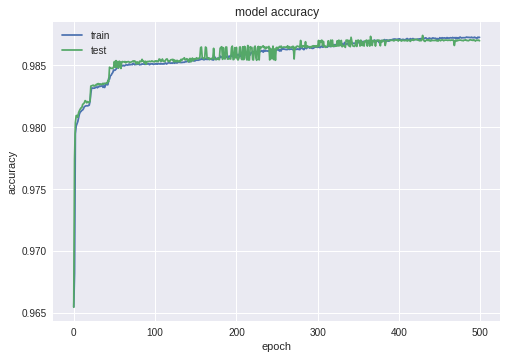

In [58]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("ANN_accuracy.png")
plt.show()

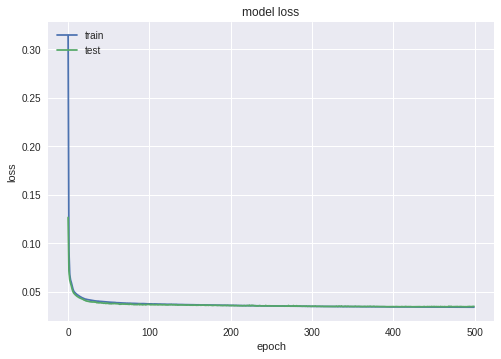

In [59]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("ANN_loss.png")
plt.show()

In [60]:
model1.evaluate(X_test_svd,y_test)

39326/39326 [==============================] - 3s 67us/step


[0.03493380678262055, 0.9869806235060774]

In [0]:
pred = model1.predict(X_test_svd)


In [0]:
y_pred_keras = model1.predict(X_test_svd).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [0]:
auc_keras = auc(fpr_keras, tpr_keras)

In [0]:
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train_svd, y_train)

y_pred_rf = rf.predict_proba(X_test_svd)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

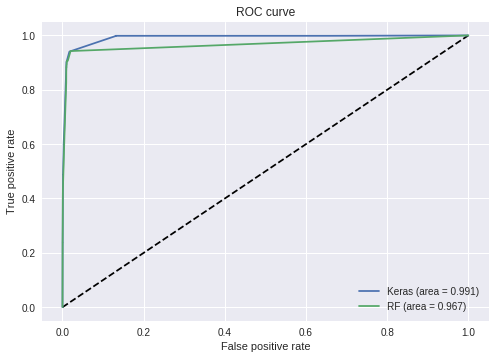

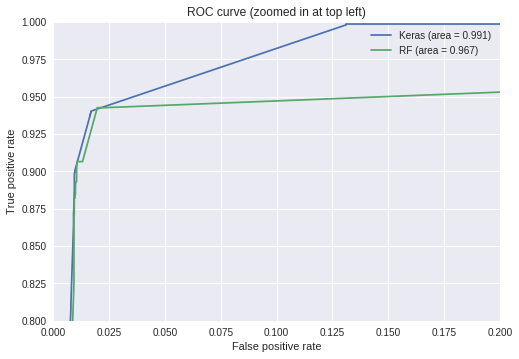

In [65]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [0]:
lod = []
for el in pred:
  if el >= 0.5:
    lod.append(1)
  else:
    lod.append(0)

In [0]:
lod = np.array(lod)

In [68]:
print("\n########### Precision score is {} ###########\n".format(precision_score(y_test,lod)))
print("\n########### Recall Score is of {} ###########\n".format(recall_score(y_test,lod)))
print("\n############# F1 Score is of {} #############\n".format(f1_score(y_test,lod)))
print("\n########## Accuracy Score is of {} ##########\n".format(accuracy_score(y_test,lod)))


########### Precision score is 0.7732558139534884 ###########


########### Recall Score is of 0.8814432989690721 ###########


############# F1 Score is of 0.82381280110117 #############


########## Accuracy Score is of 0.9869806235060774 ##########

